<>:207: SyntaxWarning: invalid escape sequence '\s'
<>:207: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3309860809.py:207: SyntaxWarning: invalid escape sequence '\s'
  userPattern       = '@[^\s]+'
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


LOADING DATASET
Dataset loaded successfully!
Dataset shape: (1600000, 6)

First few rows:
   sentiment          id                          date     query  \
0          0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1          0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2          0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3          0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4          0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

           user_id                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600

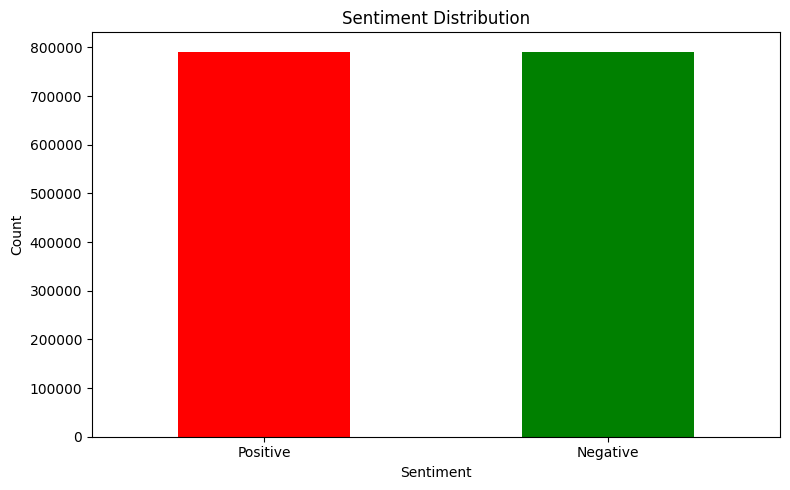


TEXT PREPROCESSING
Preprocessing text... This may take a few minutes...
Rows after removing empty texts: 1581152 (removed 314 rows)

📝 Example Preprocessed Texts:
--------------------------------------------------------------------------------
Text 1: USER URL aww bummer shoulda got david carr third day EMOJIwink...
Sentiment: Negative
--------------------------------------------------------------------------------
Text 2: upset cannot update facebook texting might cry result school today also blah...
Sentiment: Negative
--------------------------------------------------------------------------------
Text 3: USER dived many time ball managed save 50 rest go bound...
Sentiment: Negative
--------------------------------------------------------------------------------

Text length statistics:
count    1.581152e+06
mean     7.899755e+00
std      4.037378e+00
min      1.000000e+00
25%      5.000000e+00
50%      7.000000e+00
75%      1.100000e+01
max      5.000000e+01
Name: text_length, dty

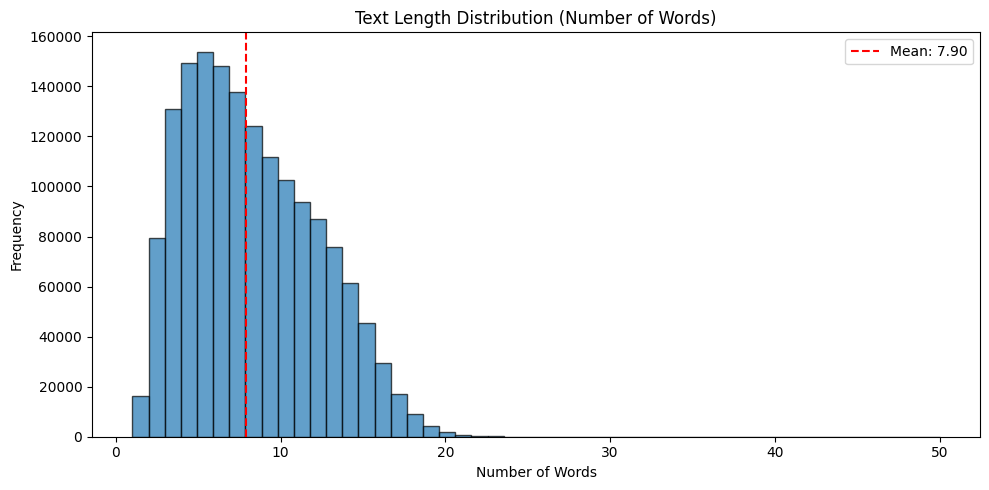


TRAIN-TEST SPLIT
Train Data size: 1423036 (90.0%)
Test Data size: 158116 (9.999999999999998%)

Train sentiment distribution:
sentiment
Positive    712012
Negative    711024
Name: count, dtype: int64

Test sentiment distribution:
sentiment
Positive    79113
Negative    79003
Name: count, dtype: int64

TOKENIZATION FOR DEEP LEARNING
Vocabulary Size: 234563
Training X Shape: (1423036, 45)
Testing X Shape: (158116, 45)

LABEL ENCODING
Unique labels: ['Negative', 'Positive']
y_train shape: (1423036, 1)
y_test shape: (158116, 1)
Label mapping: {np.str_('Negative'): np.int64(0), np.str_('Positive'): np.int64(1)}

TF-IDF VECTORIZATION
Vectoriser fitted.
No. of feature words: 100000
Data Transformed.
X_train_tfidf shape: (1423036, 100000)
X_test_tfidf shape: (158116, 100000)

SAVING PREPROCESSED DATA
✅ Tokenizer saved to 'tokenizer.pickle'
✅ Label encoder saved to 'label_encoder.pickle'
✅ TF-IDF vectorizer saved to 'tfidf_vectorizer.pickle'
✅ Sequences saved as .npy files
✅ TF-IDF matrices sav

In [ ]:
# ============================================
# 1. IMPORT LIBRARIES
# ============================================
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# NLTK imports
import nltk
nltk.download('stopwords')
nltk.download('punkt')  # Add this for better tokenization
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer

# Keras imports
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# ============================================
# 2. CONFIGURATION PARAMETERS
# ============================================
# Centralize all parameters for easy modification
CONFIG = {
    'TRAIN_SIZE': 0.9,
    'MAX_NB_WORDS': 100000,
    'MAX_SEQUENCE_LENGTH': 45,
    'TFIDF_MAX_FEATURES': 100000,  # Reduced from 500000 to prevent overfitting
    'TFIDF_NGRAM_RANGE': (1, 2),   # Changed from (1,3) - bigrams only, trigrams too sparse
    'RANDOM_STATE': 42,
    'DATASET_PATH': 'training.1600000.processed.noemoticon.csv',
    'ENCODING': 'latin'
}

# ============================================
# 2.1. PREPROCESSING CONSTANTS (FROM anotherone.py)
# ============================================

# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

# Contractions dictionary for expansion
contractions = {
    "ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have",
    "'cause": "because", "could've": "could have", "couldn't": "could not", "couldn't've": "could not have",
    "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not",
    "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", "he'd": "he would",
    "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have", "he's": "he is",
    "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
    "i'd": "i would", "i'd've": "i would have", "i'll": "i will", "i'll've": "i will have",
    "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is",
    "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have",
    "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not",
    "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock",
    "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will",
    "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not",
    "shouldn't've": "should not have", "so've": "so have", "so's": "so is", "that'd": "that would",
    "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have",
    "there's": "there is", "they'd": "they would", "they'd've": "they would have", "they'll": "they will",
    "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
    "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will",
    "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not",
    "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is",
    "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
    "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have",
    "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have",
    "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have",
    "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
    "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have", "you'd": "you would",
    "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are",
    "you've": "you have"
}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

# ============================================
# 3. LOAD AND EXPLORE DATA
# ============================================
print("="*60)
print("LOADING DATASET")
print("="*60)

# Load dataset with proper column names
df = pd.read_csv(
    CONFIG['DATASET_PATH'],
    encoding=CONFIG['ENCODING'],
    header=None,
    names=['sentiment', 'id', 'date', 'query', 'user_id', 'text']
)

print(f"Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())

# Basic data exploration
print(f"\nDataset Info:")
print(df.info())

print(f"\nMissing values:")
print(df.isnull().sum())

print(f"\nOriginal sentiment distribution:")
print(df.sentiment.value_counts())

# ============================================
# 4. DATA CLEANING
# ============================================
print("\n" + "="*60)
print("DATA CLEANING")
print("="*60)

# Drop unnecessary columns
columns_to_drop = ['id', 'date', 'query', 'user_id']
df = df.drop(columns_to_drop, axis=1)
print(f"Dropped columns: {columns_to_drop}")

# Handle missing values (if any)
initial_rows = len(df)
df = df.dropna(subset=['text', 'sentiment'])
print(f"Rows after removing missing values: {len(df)} (removed {initial_rows - len(df)} rows)")

# Remove duplicate texts
initial_rows = len(df)
df = df.drop_duplicates(subset=['text'], keep='first')
print(f"Rows after removing duplicates: {len(df)} (removed {initial_rows - len(df)} rows)")

# ============================================
# 5. LABEL ENCODING
# ============================================
print("\n" + "="*60)
print("LABEL PROCESSING")
print("="*60)

# Map sentiment labels
lab_to_sentiment = {0: "Negative", 4: "Positive"}

def label_decoder(label):
    """Decode numeric sentiment to text label"""
    return lab_to_sentiment.get(label, "Unknown")

df['sentiment'] = df['sentiment'].apply(label_decoder)

print(f"Sentiment distribution after decoding:")
print(df.sentiment.value_counts())

# Visualize class distribution
plt.figure(figsize=(8, 5))
df.sentiment.value_counts().plot(kind='bar', color=['red', 'green'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# ============================================
# 6. TEXT PREPROCESSING
# ============================================
print("\n" + "="*60)
print("TEXT PREPROCESSING")
print("="*60)

# Initialize stopwords and stemmer
# Initialize stopwords and stemmer/lemmatizer
# Using the list from anotherone.py for consistency, or we could use nltk's set
stop_words = set(stopwordlist)
stemmer = SnowballStemmer('english')
wordLemm = WordNetLemmatizer()

# Regex patterns (from anotherone.py)
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern       = '@[^\s]+'
alphaPattern      = "[^a-zA-Z0-9?!]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

def preprocess(text, use_stemming=True):
    """
    Preprocess text by:
    1. Converting to lowercase
    2. Replacing URLs with 'URL'
    3. Replacing Emojis with 'EMOJI'+meaning
    4. Replacing Usernames with 'USER'
    5. Removing non-alphanumeric chars
    6. Reducing repeated characters (e.g. coool -> cool)
    7. Removing stopwords
    8. Lemmatization (default) or Stemming
    """
    if pd.isna(text):
        return ""

    # 1. Lowercase
    tweet = str(text).lower()

    # 1.5. Expand Contractions (NEW STEP)
    # Check if words in the tweet correspond to a contraction
    for word in tweet.split():
        if word in contractions:
             tweet = tweet.replace(word, contractions[word])

    # 2. Replace URLs
    tweet = re.sub(urlPattern, ' URL', tweet)

    # 3. Replace Emojis
    for emoji in emojis.keys():
        tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])

    # 4. Replace Usernames
    tweet = re.sub(userPattern, ' USER', tweet)

    # 5. Remove non-alphabets
    tweet = re.sub(alphaPattern, " ", tweet)

    # 5.1. Add space around punctuation (NEW STEP)
    # This treats punctuation as separate tokens
    tweet = re.sub(r'([?!])', r' \1 ', tweet)

    # 6. Replace 3+ consecutive letters with 2
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Tokenize and Process
    tweetwords = []
    for word in tweet.split():
        # 7. Check stopwords
        if word not in stop_words and len(word) > 1:
            if use_stemming:
                word = stemmer.stem(word)
            else:
                # 8. Lemmatization
                word = wordLemm.lemmatize(word)
            tweetwords.append(word)

    return " ".join(tweetwords)

# Apply preprocessing
print("Preprocessing text... This may take a few minutes...")
df['text'] = df['text'].apply(lambda x: preprocess(x, use_stemming=False))

# Remove empty texts after preprocessing
initial_rows = len(df)
df = df[df['text'].str.strip() != '']
print(f"Rows after removing empty texts: {len(df)} (removed {initial_rows - len(df)} rows)")

# Show examples
print("\n📝 Example Preprocessed Texts:")
print("-" * 80)
for i in range(min(3, len(df))):
    print(f"Text {i+1}: {df['text'].iloc[i][:150]}...")
    print(f"Sentiment: {df['sentiment'].iloc[i]}")
    print("-" * 80)

# Text length analysis
df['text_length'] = df['text'].apply(lambda x: len(x.split()))
print(f"\nText length statistics:")
print(df['text_length'].describe())

# Visualize text length distribution
plt.figure(figsize=(10, 5))
plt.hist(df['text_length'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Text Length Distribution (Number of Words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.axvline(df['text_length'].mean(), color='red', linestyle='--', label=f'Mean: {df["text_length"].mean():.2f}')
plt.legend()
plt.tight_layout()
plt.show()

# ============================================
# 7. TRAIN-TEST SPLIT
# ============================================
print("\n" + "="*60)
print("TRAIN-TEST SPLIT")
print("="*60)

train_data, test_data = train_test_split(
    df,
    test_size=1-CONFIG['TRAIN_SIZE'],
    random_state=CONFIG['RANDOM_STATE'],
    stratify=df['sentiment']  # Maintain class distribution
)

print(f"Train Data size: {len(train_data)} ({CONFIG['TRAIN_SIZE']*100}%)")
print(f"Test Data size: {len(test_data)} ({(1-CONFIG['TRAIN_SIZE'])*100}%)")

print(f"\nTrain sentiment distribution:")
print(train_data.sentiment.value_counts())

print(f"\nTest sentiment distribution:")
print(test_data.sentiment.value_counts())

# ============================================
# 8. TOKENIZATION FOR DEEP LEARNING
# ============================================
print("\n" + "="*60)
print("TOKENIZATION FOR DEEP LEARNING")
print("="*60)

# Initialize and fit tokenizer
tokenizer = Tokenizer(num_words=CONFIG['MAX_NB_WORDS'])
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print(f"Vocabulary Size: {vocab_size}")

# Convert texts to sequences
x_train = pad_sequences(
    tokenizer.texts_to_sequences(train_data.text),
    maxlen=CONFIG['MAX_SEQUENCE_LENGTH'],
    padding='post',  # Pad at the end
    truncating='post'  # Truncate at the end
)

x_test = pad_sequences(
    tokenizer.texts_to_sequences(test_data.text),
    maxlen=CONFIG['MAX_SEQUENCE_LENGTH'],
    padding='post',
    truncating='post'
)

print(f"Training X Shape: {x_train.shape}")
print(f"Testing X Shape: {x_test.shape}")

# ============================================
# 9. LABEL ENCODING FOR DEEP LEARNING
# ============================================
print("\n" + "="*60)
print("LABEL ENCODING")
print("="*60)

# Get unique labels
labels = train_data.sentiment.unique().tolist()
print(f"Unique labels: {labels}")

# Encode labels
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Label mapping: {dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))}")

# ============================================
# 10. TF-IDF VECTORIZATION FOR ML MODELS
# ============================================
print("\n" + "="*60)
print("TF-IDF VECTORIZATION")
print("="*60)

# Initialize TF-IDF vectorizer
vectoriser = TfidfVectorizer(
    ngram_range=CONFIG['TFIDF_NGRAM_RANGE'],
    max_features=CONFIG['TFIDF_MAX_FEATURES'],
    min_df=3,  # Increased from 2 to filter rare terms
    max_df=0.95,
    sublinear_tf=True,  # Logarithmic scaling
    strip_accents='unicode'
)

# Fit on training data only
vectoriser.fit(train_data.text)
print(f'Vectoriser fitted.')
print(f'No. of feature words: {len(vectoriser.get_feature_names_out())}')

# Transform data
X_train_tfidf = vectoriser.transform(train_data.text)
X_test_tfidf = vectoriser.transform(test_data.text)

print(f'Data Transformed.')
print(f'X_train_tfidf shape: {X_train_tfidf.shape}')
print(f'X_test_tfidf shape: {X_test_tfidf.shape}')

# ============================================
# 11. SAVE PREPROCESSED DATA (OPTIONAL)
# ============================================
print("\n" + "="*60)
print("SAVING PREPROCESSED DATA")
print("="*60)

# Save tokenizer
import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("✅ Tokenizer saved to 'tokenizer.pickle'")

# Save label encoder
with open('label_encoder.pickle', 'wb') as handle:
    pickle.dump(encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("✅ Label encoder saved to 'label_encoder.pickle'")

# Save TF-IDF vectorizer
with open('tfidf_vectorizer.pickle', 'wb') as handle:
    pickle.dump(vectoriser, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("✅ TF-IDF vectorizer saved to 'tfidf_vectorizer.pickle'")

# Save preprocessed sequences
np.save('x_train_sequences.npy', x_train)
np.save('x_test_sequences.npy', x_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)
print("✅ Sequences saved as .npy files")

# Save TF-IDF matrices (sparse format)
from scipy.sparse import save_npz
save_npz('X_train_tfidf.npz', X_train_tfidf)
save_npz('X_test_tfidf.npz', X_test_tfidf)
print("✅ TF-IDF matrices saved as .npz files")

print("\n" + "="*60)
print("PREPROCESSING COMPLETE!")
print("="*60)

# ============================================
# 12. SUMMARY STATISTICS
# ============================================
print("\n📊 FINAL SUMMARY:")
print("-" * 60)
print(f"Total samples: {len(df)}")
print(f"Training samples: {len(train_data)}")
print(f"Testing samples: {len(test_data)}")
print(f"Vocabulary size: {vocab_size}")
print(f"Max sequence length: {CONFIG['MAX_SEQUENCE_LENGTH']}")
print(f"TF-IDF features: {X_train_tfidf.shape[1]}")
print(f"Average text length: {df['text_length'].mean():.2f} words")
print("-" * 60)


MEMORY-OPTIMIZED LOGISTIC REGRESSION

STEP 3: TRAIN LOGISTIC REGRESSION MODEL

🚀 Training started...
   Samples: 1,423,036, Features: 100,000
   Batch size: 5,000
   Learning rate: 0.5, Iterations: 1000
   Memory-efficient mode: Using sparse matrices
----------------------------------------------------------------------
Epoch    0/1000 | Loss: 0.685308 | Time: 0.77s
Epoch   50/1000 | Loss: 0.520241 | Time: 60.74s
Epoch  100/1000 | Loss: 0.490328 | Time: 111.06s
Epoch  150/1000 | Loss: 0.475406 | Time: 147.55s
Epoch  200/1000 | Loss: 0.465860 | Time: 182.70s
Epoch  250/1000 | Loss: 0.458979 | Time: 218.29s
Epoch  300/1000 | Loss: 0.453663 | Time: 255.72s
Epoch  350/1000 | Loss: 0.449360 | Time: 290.77s
Epoch  400/1000 | Loss: 0.445761 | Time: 325.59s
Epoch  450/1000 | Loss: 0.442679 | Time: 361.24s
Epoch  500/1000 | Loss: 0.439989 | Time: 394.97s
Epoch  550/1000 | Loss: 0.437609 | Time: 430.40s
Epoch  600/1000 | Loss: 0.435476 | Time: 466.26s
Epoch  650/1000 | Loss: 0.433545 | Time: 501

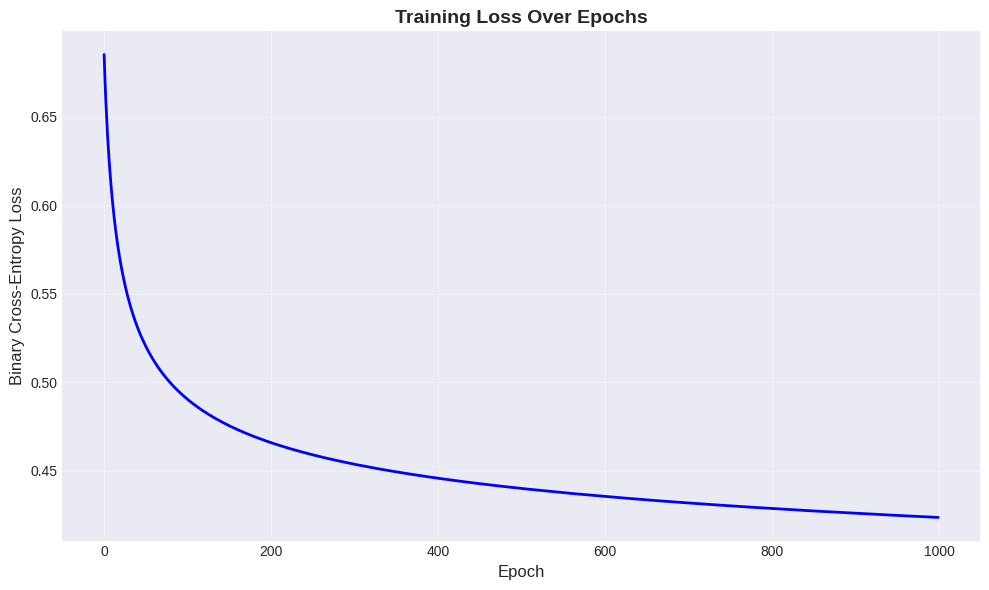


STEP 4: MAKING PREDICTIONS

📊 Predicting on training set...
📊 Predicting on test set...
✅ Predictions completed!

STEP 5: MODEL EVALUATION - TRAINING SET

📈 Training Set Performance:
   Accuracy:  0.8108 (81.08%)
   Precision: 0.8031
   Recall:    0.8240
   F1-Score:  0.8134

MODEL EVALUATION - TEST SET

📈 Test Set Performance:
   Accuracy:  0.8037 (80.37%)
   Precision: 0.7974
   Recall:    0.8148
   F1-Score:  0.8060

DETAILED CLASSIFICATION REPORT

               precision    recall  f1-score   support

    Negative     0.8104    0.7927    0.8014     79003
    Positive     0.7974    0.8148    0.8060     79113

    accuracy                         0.8037    158116
   macro avg     0.8039    0.8037    0.8037    158116
weighted avg     0.8039    0.8037    0.8037    158116


STEP 6: CONFUSION MATRIX


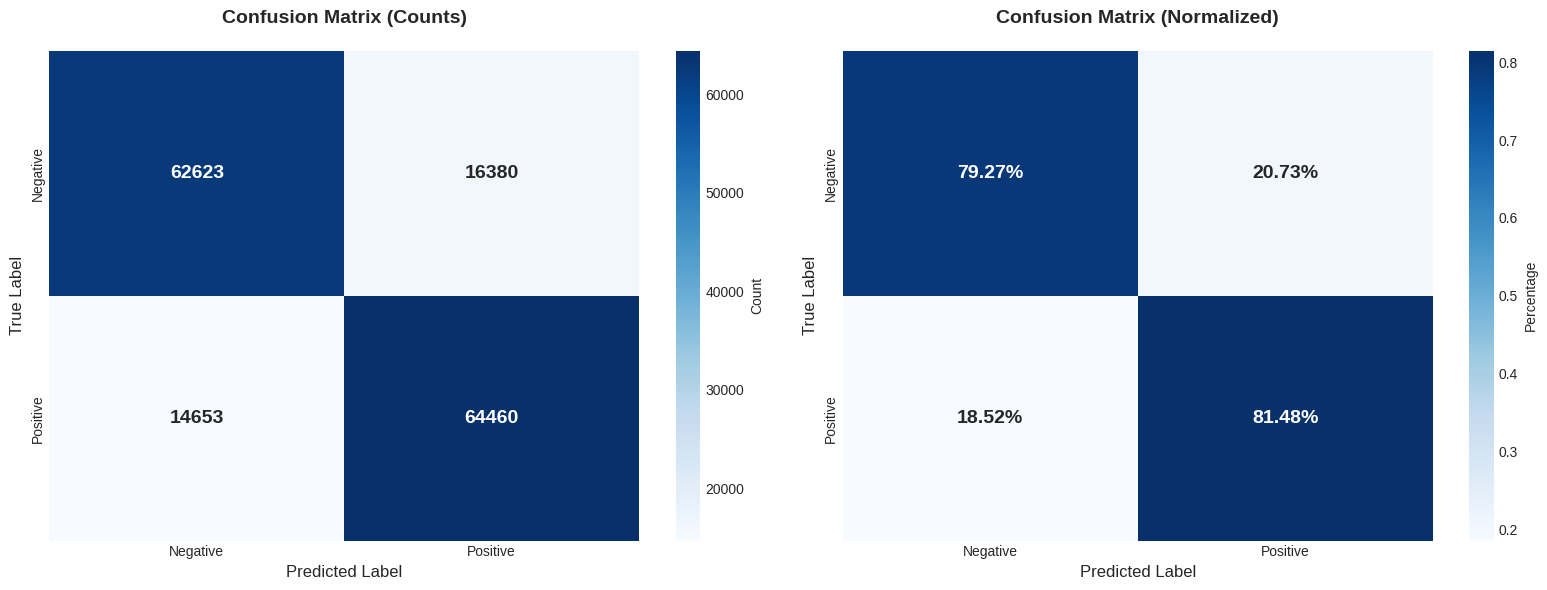


Confusion Matrix Details:
  True Negatives:  62,623
  False Positives: 16,380
  False Negatives: 14,653
  True Positives:  64,460

  Specificity: 0.7927
  Sensitivity: 0.8148

STEP 7: ROC CURVE & AUC SCORE

🎯 ROC-AUC Score: 0.8835
   Interpretation: Good


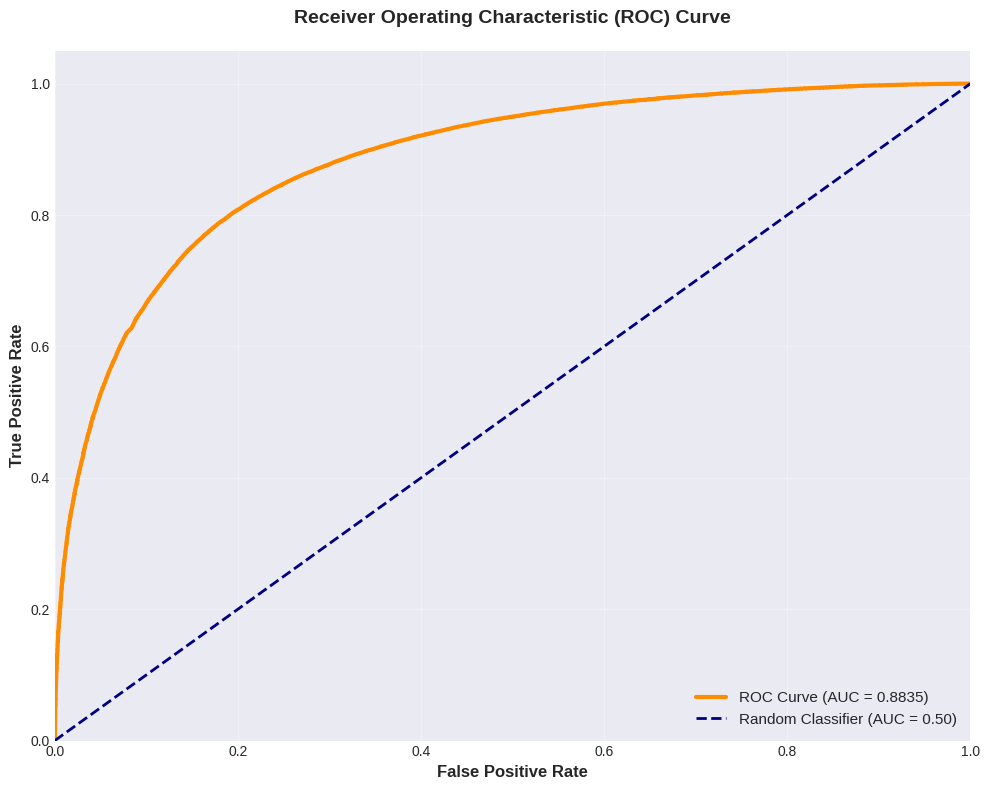


STEP 8: PRECISION-RECALL CURVE

🎯 Average Precision Score: 0.8840


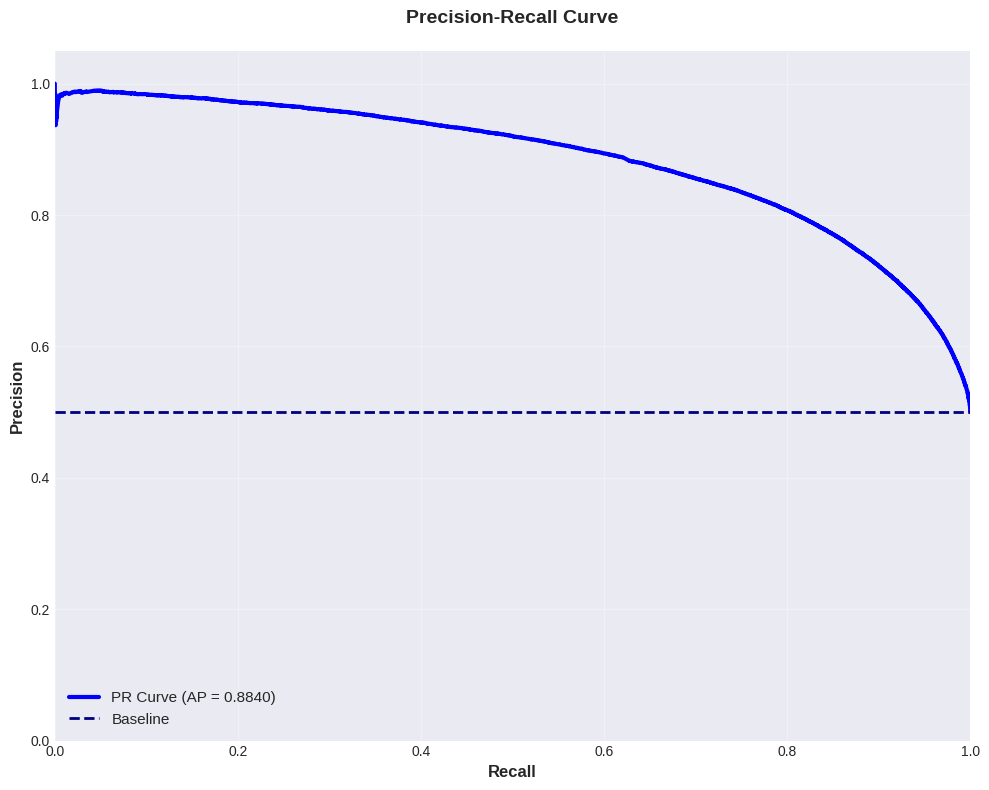


FINAL PERFORMANCE SUMMARY

        Metric Training   Test
     Accuracy   0.8108 0.8037
    Precision   0.8031 0.7974
       Recall   0.8240 0.8148
     F1-Score   0.8134 0.8060
      ROC-AUC      N/A 0.8835
Avg Precision      N/A 0.8840


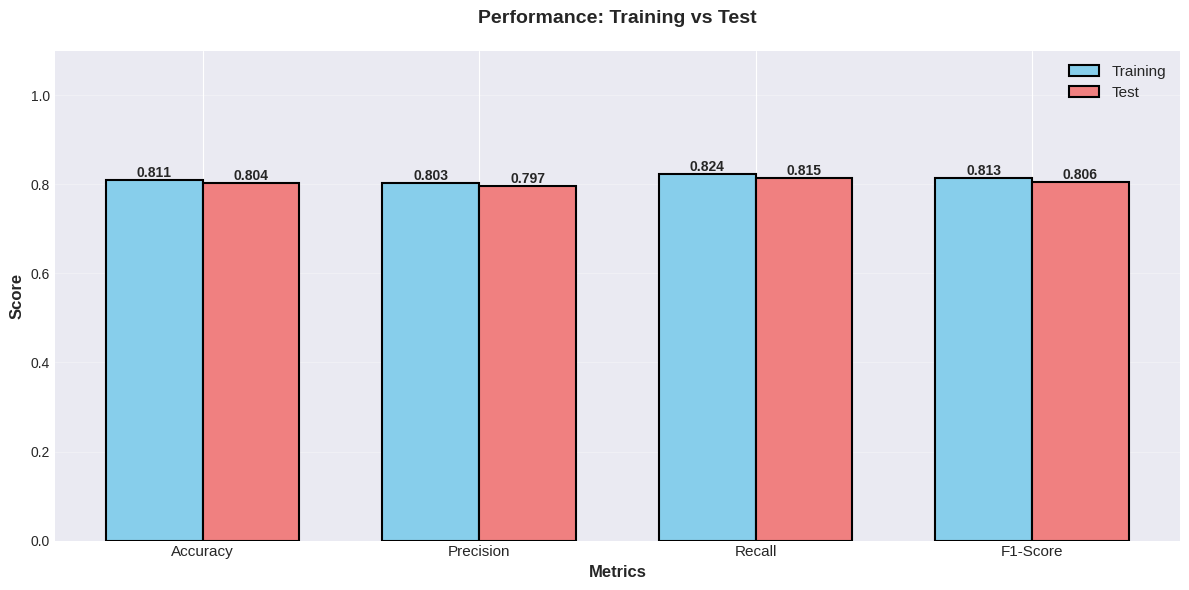


✅ LOGISTIC REGRESSION COMPLETE!


In [ ]:
# ============================================
#  LOGISTIC REGRESSION
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, classification_report
)
from scipy.sparse import load_npz
import time
import gc

# Load data
X_train_tfidf = load_npz('X_train_tfidf.npz')
y_train = np.load('y_train.npy')
X_test_tfidf = load_npz('X_test_tfidf.npz')
y_test = np.load('y_test.npy')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*70)
print("MEMORY-OPTIMIZED LOGISTIC REGRESSION")
print("="*70)

# ============================================
# 1. LOGISTIC REGRESSION CLASS
# ============================================

class LogisticRegressionOptimized:
    """
    Memory-optimized Logistic Regression for large sparse datasets
    """

    def __init__(self, learning_rate=0.1, n_iterations=1000, batch_size=10000, verbose=True):
        """
        Initialize model with mini-batch gradient descent

        Parameters:
        -----------
        learning_rate : float
            Learning rate for gradient descent
        n_iterations : int
            Number of iterations (epochs)
        batch_size : int
            Size of mini-batches for gradient descent
        verbose : bool
            Whether to print training progress
        """
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.batch_size = batch_size
        self.verbose = verbose
        self.weights = None
        self.bias = None
        self.losses = []

    def sigmoid(self, z):
        """Sigmoid activation with numerical stability"""
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def compute_loss(self, y_true, y_pred):
        """Compute binary cross-entropy loss"""
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        return loss

    def fit(self, X, y):
        """
        Train using mini-batch gradient descent

        Parameters:
        -----------
        X : sparse matrix, shape (n_samples, n_features)
            Training data (TF-IDF sparse matrix)
        y : array-like, shape (n_samples,)
            Target values
        """
        # Keep X as sparse matrix
        n_samples, n_features = X.shape
        y = np.array(y, dtype=np.float32).reshape(-1, 1)

        # Initialize weights (keep as regular array, not sparse)
        self.weights = np.zeros((n_features, 1), dtype=np.float32)
        self.bias = 0.0

        print(f"\n🚀 Training started...")
        print(f"   Samples: {n_samples:,}, Features: {n_features:,}")
        print(f"   Batch size: {self.batch_size:,}")
        print(f"   Learning rate: {self.learning_rate}, Iterations: {self.n_iterations}")
        print(f"   Memory-efficient mode: Using sparse matrices")
        print("-" * 70)

        start_time = time.time()
        n_batches = int(np.ceil(n_samples / self.batch_size))

        # Training loop
        for epoch in range(self.n_iterations):
            epoch_loss = 0.0
            indices = np.random.permutation(n_samples)

            # Mini-batch gradient descent
            for batch_idx in range(n_batches):
                # Get batch indices
                start_idx = batch_idx * self.batch_size
                end_idx = min((batch_idx + 1) * self.batch_size, n_samples)
                batch_indices = indices[start_idx:end_idx]

                # Get batch data (X_batch stays sparse)
                X_batch = X[batch_indices]
                y_batch = y[batch_indices]

                # Forward pass (sparse matrix multiplication)
                linear_model = X_batch.dot(self.weights) + self.bias
                y_pred = self.sigmoid(linear_model)

                # Compute loss
                batch_loss = self.compute_loss(y_batch, y_pred)
                epoch_loss += batch_loss * len(batch_indices)

                # Backward pass (compute gradients)
                error = y_pred - y_batch
                dw = (X_batch.T.dot(error)) / len(batch_indices)  # Sparse matrix operation
                db = np.mean(error)

                # Update parameters
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db

            # Average loss for the epoch
            avg_loss = epoch_loss / n_samples
            self.losses.append(avg_loss)

            # Print progress
            if self.verbose and (epoch % 50 == 0 or epoch == self.n_iterations - 1):
                elapsed = time.time() - start_time
                print(f"Epoch {epoch:4d}/{self.n_iterations} | "
                      f"Loss: {avg_loss:.6f} | "
                      f"Time: {elapsed:.2f}s")

            # Garbage collection every 100 epochs
            if epoch % 100 == 0:
                gc.collect()

        training_time = time.time() - start_time
        print("-" * 70)
        print(f"✅ Training completed in {training_time:.2f} seconds")
        print(f"   Final loss: {self.losses[-1]:.6f}")

    def predict_proba(self, X, batch_size=50000):
        """
        Predict probabilities in batches to save memory
        """
        n_samples = X.shape[0]
        n_batches = int(np.ceil(n_samples / batch_size))
        predictions = np.zeros(n_samples, dtype=np.float32)

        for batch_idx in range(n_batches):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, n_samples)

            X_batch = X[start_idx:end_idx]
            linear_model = X_batch.dot(self.weights) + self.bias
            predictions[start_idx:end_idx] = self.sigmoid(linear_model).flatten()

        return predictions

    def predict(self, X, threshold=0.5, batch_size=50000):
        """Predict class labels"""
        probabilities = self.predict_proba(X, batch_size)
        return (probabilities >= threshold).astype(int)

    def plot_loss(self):
        """Plot training loss curve"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.losses, linewidth=2, color='blue')
        plt.title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Binary Cross-Entropy Loss', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

# ============================================
# 4. TRAIN MODEL
# ============================================

print("\n" + "="*70)
print("STEP 3: TRAIN LOGISTIC REGRESSION MODEL")
print("="*70)

# Initialize model with optimized parameters
lr_model = LogisticRegressionOptimized(
    learning_rate=0.5,       # Higher learning rate for faster convergence
    n_iterations=1000,        # Fewer iterations needed with mini-batch
    batch_size=5000,        # Process 10k samples at a time
    verbose=True
)

# Train model
lr_model.fit(X_train_tfidf, y_train)

# Plot training loss
lr_model.plot_loss()

# Garbage collection after training
gc.collect()

# ============================================
# 5. MAKE PREDICTIONS
# ============================================

print("\n" + "="*70)
print("STEP 4: MAKING PREDICTIONS")
print("="*70)

# Predict on training set (in batches)
print("\n📊 Predicting on training set...")
y_train_pred = lr_model.predict(X_train_tfidf, batch_size=5000)
y_train_proba = lr_model.predict_proba(X_train_tfidf, batch_size=5000)
gc.collect()

# Predict on test set (in batches)
print("📊 Predicting on test set...")
y_test_pred = lr_model.predict(X_test_tfidf, batch_size=5000)
y_test_proba = lr_model.predict_proba(X_test_tfidf, batch_size=5000)
gc.collect()

print("✅ Predictions completed!")

# ============================================
# 6. EVALUATION METRICS
# ============================================

print("\n" + "="*70)
print("STEP 5: MODEL EVALUATION - TRAINING SET")
print("="*70)

train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

print(f"\n📈 Training Set Performance:")
print(f"   Accuracy:  {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"   Precision: {train_precision:.4f}")
print(f"   Recall:    {train_recall:.4f}")
print(f"   F1-Score:  {train_f1:.4f}")

print("\n" + "="*70)
print("MODEL EVALUATION - TEST SET")
print("="*70)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"\n📈 Test Set Performance:")
print(f"   Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   Precision: {test_precision:.4f}")
print(f"   Recall:    {test_recall:.4f}")
print(f"   F1-Score:  {test_f1:.4f}")

print("\n" + "="*70)
print("DETAILED CLASSIFICATION REPORT")
print("="*70)
print("\n", classification_report(y_test, y_test_pred,
                                   target_names=['Negative', 'Positive'],
                                   digits=4))

# ============================================
# 7. CONFUSION MATRIX
# ============================================

print("\n" + "="*70)
print("STEP 6: CONFUSION MATRIX")
print("="*70)

cm = confusion_matrix(y_test, y_test_pred)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            cbar_kws={'label': 'Count'},
            ax=axes[0],
            annot_kws={'size': 14, 'weight': 'bold'})
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold', pad=20)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Normalized
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            cbar_kws={'label': 'Percentage'},
            ax=axes[1],
            annot_kws={'size': 14, 'weight': 'bold'})
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold', pad=20)
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()

print("\nConfusion Matrix Details:")
print(f"  True Negatives:  {cm[0, 0]:,}")
print(f"  False Positives: {cm[0, 1]:,}")
print(f"  False Negatives: {cm[1, 0]:,}")
print(f"  True Positives:  {cm[1, 1]:,}")

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"\n  Specificity: {specificity:.4f}")
print(f"  Sensitivity: {sensitivity:.4f}")

# ============================================
# 8. ROC CURVE AND AUC
# ============================================

print("\n" + "="*70)
print("STEP 7: ROC CURVE & AUC SCORE")
print("="*70)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

print(f"\n🎯 ROC-AUC Score: {roc_auc:.4f}")

if roc_auc >= 0.90:
    interpretation = "Excellent"
elif roc_auc >= 0.80:
    interpretation = "Good"
elif roc_auc >= 0.70:
    interpretation = "Fair"
else:
    interpretation = "Poor"
print(f"   Interpretation: {interpretation}")

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=3,
         label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
         label='Random Classifier (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('Receiver Operating Characteristic (ROC) Curve',
          fontsize=14, fontweight='bold', pad=20)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================
# 9. PRECISION-RECALL CURVE
# ============================================

print("\n" + "="*70)
print("STEP 8: PRECISION-RECALL CURVE")
print("="*70)

from sklearn.metrics import precision_recall_curve, average_precision_score

precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_test, y_test_proba)
average_precision = average_precision_score(y_test, y_test_proba)

print(f"\n🎯 Average Precision Score: {average_precision:.4f}")

plt.figure(figsize=(10, 8))
plt.plot(recall_curve, precision_curve, color='blue', lw=3,
         label=f'PR Curve (AP = {average_precision:.4f})')
plt.axhline(y=np.sum(y_test)/len(y_test), color='navy', lw=2,
            linestyle='--', label=f'Baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold', pad=20)
plt.legend(loc="lower left", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================
# 10. PERFORMANCE SUMMARY
# ============================================

print("\n" + "="*70)
print("FINAL PERFORMANCE SUMMARY")
print("="*70)

summary_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Avg Precision'],
    'Training': [f"{train_accuracy:.4f}", f"{train_precision:.4f}",
                 f"{train_recall:.4f}", f"{train_f1:.4f}", "N/A", "N/A"],
    'Test': [f"{test_accuracy:.4f}", f"{test_precision:.4f}",
             f"{test_recall:.4f}", f"{test_f1:.4f}",
             f"{roc_auc:.4f}", f"{average_precision:.4f}"]
}

summary_df = pd.DataFrame(summary_data)
print("\n", summary_df.to_string(index=False))

# Visualize metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
train_scores = [train_accuracy, train_precision, train_recall, train_f1]
test_scores = [test_accuracy, test_precision, test_recall, test_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, train_scores, width, label='Training',
               color='skyblue', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, test_scores, width, label='Test',
               color='lightcoral', edgecolor='black', linewidth=1.5)

ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Performance: Training vs Test', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)
ax.legend(fontsize=11)
ax.set_ylim([0, 1.1])
ax.grid(True, axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom',
                fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("✅ LOGISTIC REGRESSION COMPLETE!")
print("="*70)



INITIALIZING MODEL

TRAINING MEMORY-EFFICIENT NAIVE BAYES
Classes: 2
Features: 100000
Training samples: 1,423,036
Smoothing (alpha): 0.5
Processing class 0... ✓
Processing class 1... ✓

✓ Training completed in 1.07 seconds

MAKING PREDICTIONS
Predicting on training set...
Predicting on test set...
✓ Predictions completed in 1.64 seconds

Calculating probabilities for test set...

EVALUATION METRICS

📊 TRAINING SET PERFORMANCE:
------------------------------------------------------------
Accuracy:  0.8087
Precision: 0.8087
Recall:    0.8087
F1-Score:  0.8087

📊 TEST SET PERFORMANCE:
------------------------------------------------------------
Accuracy:  0.7904
Precision: 0.7905
Recall:    0.7904
F1-Score:  0.7904

📋 DETAILED CLASSIFICATION REPORT (TEST SET):
------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.79      0.79      0.79     79003
    Positive       0.79      0.79      0.79     79113

    ac

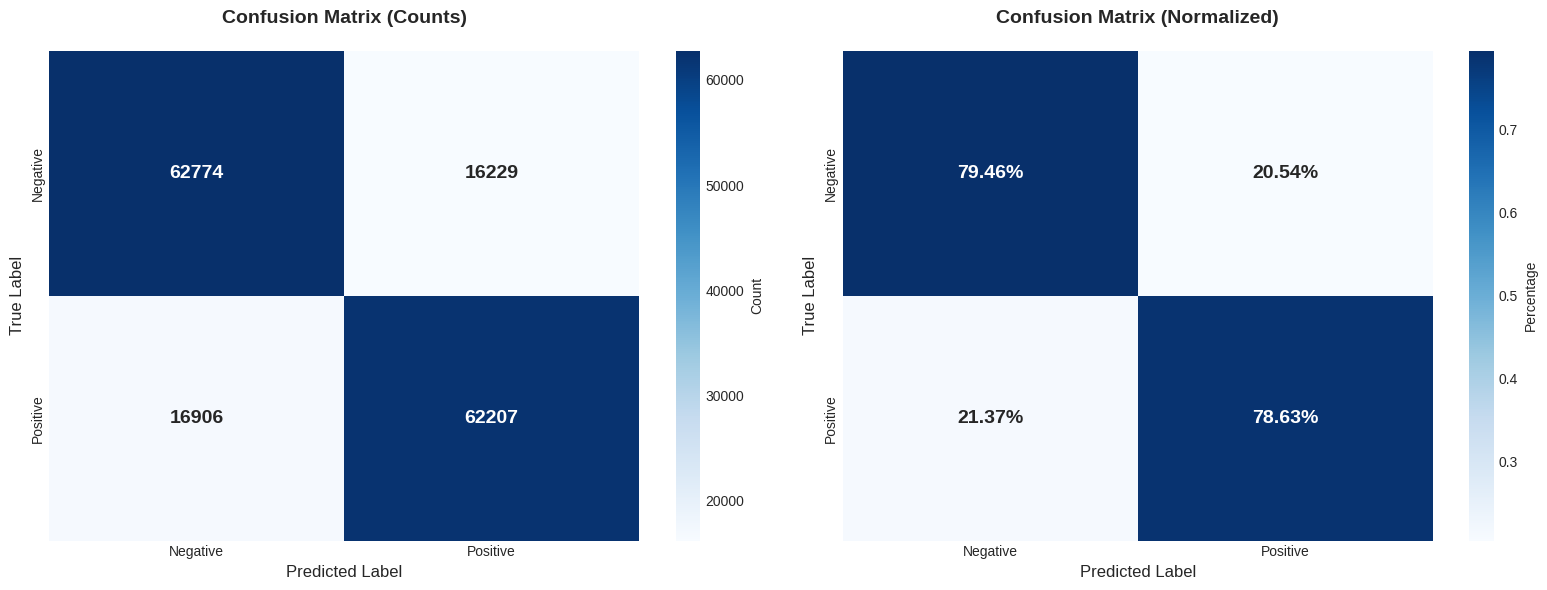

✓ Confusion matrices plotted

Confusion Matrix Details:
  True Negatives:  62,774
  False Positives: 16,229
  False Negatives: 16,906
  True Positives:  62,207

  Specificity: 0.7946
  Sensitivity: 0.7863

ROC CURVE AND AUC
Computing ROC for test set...
  Sampling 50,000 points for ROC calculation...
Test AUC:  0.8735


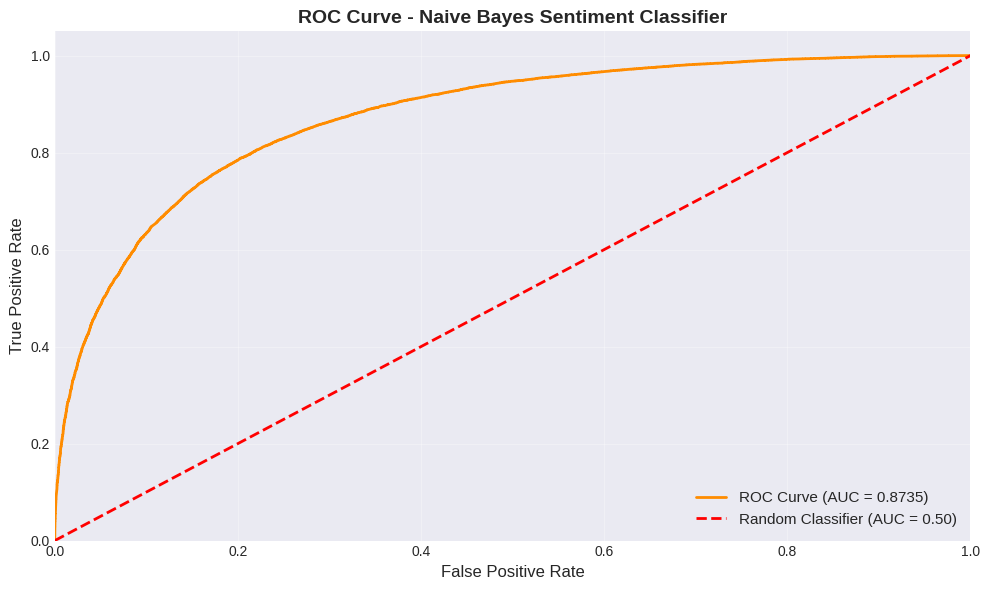

✓ ROC curve plotted

PRECISION-RECALL CURVE
Computing PR curve for test set...
  Sampling 50,000 points for PR calculation...
Test Average Precision:  0.8700


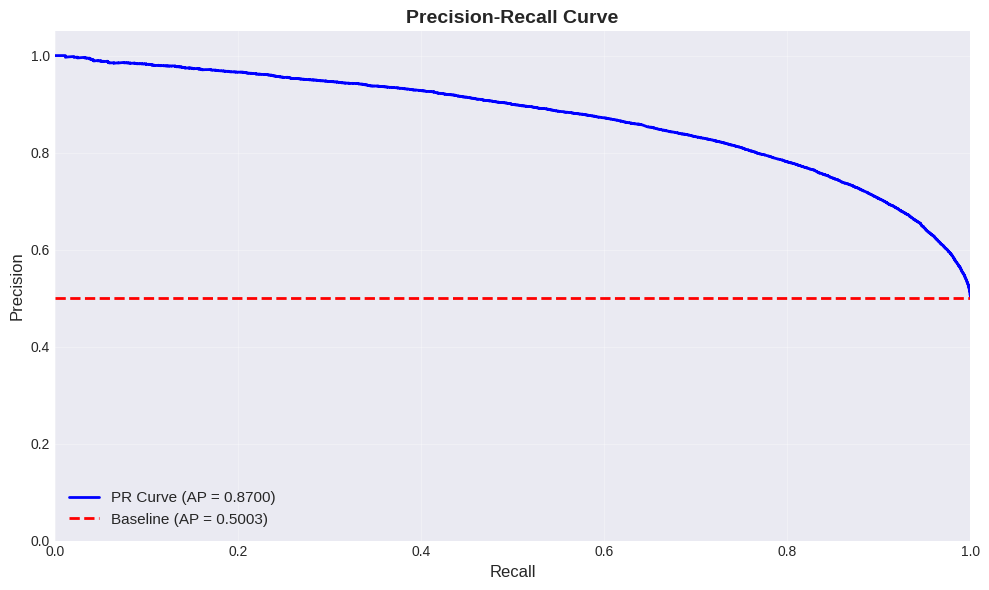

✓ Precision-Recall curve plotted

PERFORMANCE COMPARISON


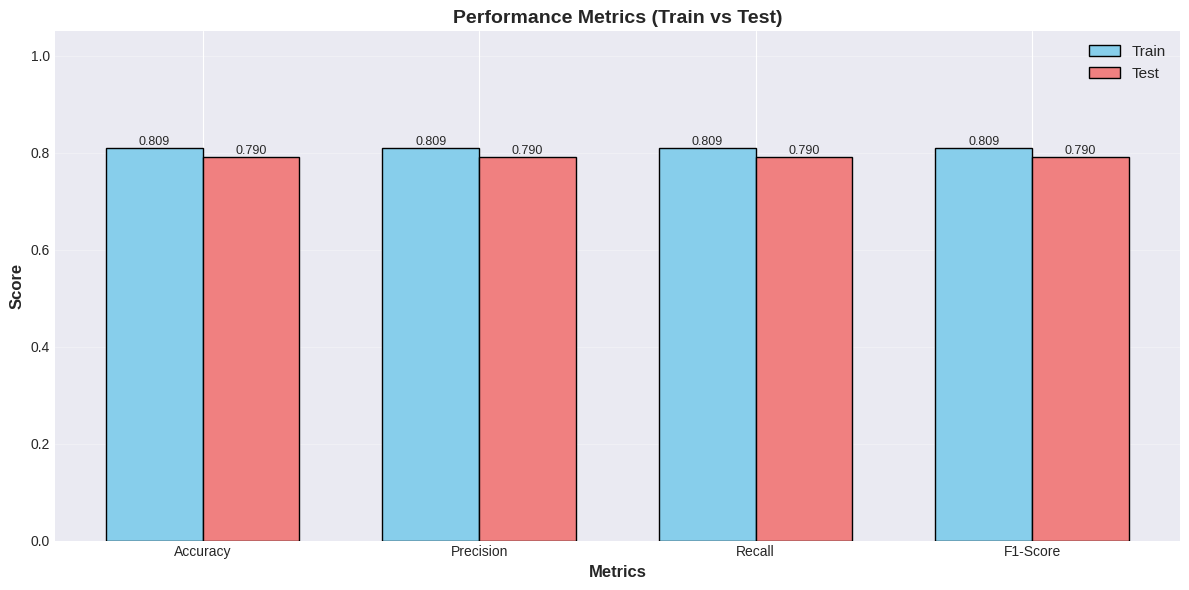

✓ Performance comparison plotted

📊 FINAL PERFORMANCE SUMMARY

METRIC               TRAIN           TEST            DIFFERENCE     
-----------------------------------------------------------------
Accuracy             0.8087          0.7904          0.0182         
Precision            0.8087          0.7905          0.0182         
Recall               0.8087          0.7904          0.0182         
F1-Score             0.8087          0.7904          0.0182         
ROC AUC              N/A             0.8735          N/A            
Avg Precision        N/A             0.8700          N/A            
-----------------------------------------------------------------

📈 MODEL ANALYSIS:
   • Average Train-Test Difference: 0.0182
   • Status: ✓ Excellent generalization

🎯 KEY FINDINGS:
   • Test Accuracy: 79.04%
   • Test F1-Score: 0.7904
   • ROC AUC: 0.8735
   • Model shows strong performance

💾 MEMORY OPTIMIZATION:
   • Used batch processing for predictions
   • Avoided dense matrix

3615

In [ ]:
# ============================================
# NAIVE BAYES
# ============================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import issparse, csr_matrix
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from scipy.sparse import load_npz
import time
import gc

# Load data
X_train_tfidf = load_npz('X_train_tfidf.npz')
y_train = np.load('y_train.npy')
X_test_tfidf = load_npz('X_test_tfidf.npz')
y_test = np.load('y_test.npy')

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================
# NAIVE BAYES CLASSIFIER
# ============================================

class MemoryEfficientNaiveBayes:
    """
    Memory-efficient Multinomial Naive Bayes classifier.
    Optimized for large datasets with limited RAM.
    """

    def __init__(self, alpha=0.1):
        """
        Initialize Naive Bayes with Laplace smoothing

        Parameters:
        -----------
        alpha : float, default=0.1
            Smoothing parameter
        """
        self.alpha = alpha
        self.classes_ = None
        self.class_prior_ = None
        self.feature_log_prob_ = None
        self.n_features_ = None

    def fit(self, X, y):
        """
        Fit classifier using sparse matrices (no conversion to dense)
        """
        print("\n" + "="*60)
        print("TRAINING MEMORY-EFFICIENT NAIVE BAYES")
        print("="*60)

        start_time = time.time()

        # Ensure X is sparse CSR format for efficiency
        if not issparse(X):
            X = csr_matrix(X)

        # Flatten y
        y = y.ravel()

        # Get unique classes
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)
        n_samples, self.n_features_ = X.shape

        print(f"Classes: {n_classes}")
        print(f"Features: {self.n_features_}")
        print(f"Training samples: {n_samples:,}")
        print(f"Smoothing (alpha): {self.alpha}")

        # Initialize arrays
        self.class_prior_ = np.zeros(n_classes, dtype=np.float32)
        self.feature_log_prob_ = np.zeros((n_classes, self.n_features_), dtype=np.float32)

        # Calculate for each class separately (memory efficient)
        for idx, c in enumerate(self.classes_):
            print(f"Processing class {c}...", end=" ")

            # Boolean mask for this class
            mask = (y == c)

            # Class prior
            self.class_prior_[idx] = mask.sum() / n_samples

            # Feature counts using sparse operations (no dense conversion!)
            X_c = X[mask]
            feature_count = np.asarray(X_c.sum(axis=0)).ravel() + self.alpha

            # Calculate log probabilities
            total_count = feature_count.sum()
            self.feature_log_prob_[idx, :] = np.log(feature_count / total_count)

            print("✓")

            # Clear memory
            del X_c, feature_count, mask
            gc.collect()

        # Convert priors to log
        self.class_prior_ = np.log(self.class_prior_)

        training_time = time.time() - start_time
        print(f"\n✓ Training completed in {training_time:.2f} seconds")

        return self

    def predict_log_proba_batch(self, X, batch_size=10000):
        """
        Calculate log probabilities in batches to save memory
        """
        if not issparse(X):
            X = csr_matrix(X)

        n_samples = X.shape[0]
        n_classes = len(self.classes_)
        log_proba = np.zeros((n_samples, n_classes), dtype=np.float32)

        # Process in batches
        for start_idx in range(0, n_samples, batch_size):
            end_idx = min(start_idx + batch_size, n_samples)
            X_batch = X[start_idx:end_idx]

            # Calculate: log(P(class)) + sum(log(P(feature|class)) * feature_value)
            log_proba[start_idx:end_idx] = (
                X_batch @ self.feature_log_prob_.T + self.class_prior_
            )

        return log_proba

    def predict(self, X, batch_size=10000):
        """
        Predict class labels in batches
        """
        log_proba = self.predict_log_proba_batch(X, batch_size)
        predictions = self.classes_[np.argmax(log_proba, axis=1)]

        # Clear memory
        del log_proba
        gc.collect()

        return predictions

    def predict_proba_batch(self, X, batch_size=10000):
        """
        Calculate probabilities in batches
        """
        log_proba = self.predict_log_proba_batch(X, batch_size)

        # Convert to probabilities using log-sum-exp trick
        log_proba_max = log_proba.max(axis=1, keepdims=True)
        exp_log_proba = np.exp(log_proba - log_proba_max)
        proba = exp_log_proba / exp_log_proba.sum(axis=1, keepdims=True)

        # Clear memory
        del log_proba, log_proba_max, exp_log_proba
        gc.collect()

        return proba

# ============================================
# ROC COMPUTATION
# ============================================

def compute_roc_auc_efficient(y_true, y_proba, batch_size=50000):
    """
    Compute ROC curve efficiently for large datasets
    """
    from sklearn.metrics import roc_curve, auc

    # Sample if dataset is too large
    n_samples = len(y_true)
    if n_samples > batch_size:
        print(f"  Sampling {batch_size:,} points for ROC calculation...")
        indices = np.random.choice(n_samples, batch_size, replace=False)
        y_true_sample = y_true[indices]
        y_proba_sample = y_proba[indices]
    else:
        y_true_sample = y_true
        y_proba_sample = y_proba

    fpr, tpr, _ = roc_curve(y_true_sample, y_proba_sample)
    roc_auc = auc(fpr, tpr)

    return fpr, tpr, roc_auc

def compute_pr_curve_efficient(y_true, y_proba, batch_size=50000):
    """
    Compute Precision-Recall curve efficiently
    """
    from sklearn.metrics import precision_recall_curve, average_precision_score

    # Sample if dataset is too large
    n_samples = len(y_true)
    if n_samples > batch_size:
        print(f"  Sampling {batch_size:,} points for PR calculation...")
        indices = np.random.choice(n_samples, batch_size, replace=False)
        y_true_sample = y_true[indices]
        y_proba_sample = y_proba[indices]
    else:
        y_true_sample = y_true
        y_proba_sample = y_proba

    precision, recall, _ = precision_recall_curve(y_true_sample, y_proba_sample)
    ap = average_precision_score(y_true_sample, y_proba_sample)

    return precision, recall, ap

# ============================================
# TRAIN THE MODEL
# ============================================

print("\n" + "="*60)
print("INITIALIZING MODEL")
print("="*60)

# Clear memory before training
gc.collect()

# Initialize classifier
nb_classifier = MemoryEfficientNaiveBayes(alpha=0.5)

# Train the model
nb_classifier.fit(X_train_tfidf, y_train)

# Clear memory
gc.collect()

# ============================================
# MAKE PREDICTIONS (BATCH PROCESSING)
# ============================================

print("\n" + "="*60)
print("MAKING PREDICTIONS")
print("="*60)

BATCH_SIZE = 50000  # Adjust based on your RAM

start_time = time.time()

print("Predicting on training set...")
y_pred_train = nb_classifier.predict(X_train_tfidf, batch_size=BATCH_SIZE)

print("Predicting on test set...")
y_pred_test = nb_classifier.predict(X_test_tfidf, batch_size=BATCH_SIZE)

prediction_time = time.time() - start_time
print(f"✓ Predictions completed in {prediction_time:.2f} seconds")

# Get probabilities for positive class (for ROC/PR curves)
print("\nCalculating probabilities for test set...")
y_proba_test = nb_classifier.predict_proba_batch(X_test_tfidf, batch_size=BATCH_SIZE)[:, 1]

# Prediction on training set is already done above.
# We don't need probability calibration for training set to save memory
gc.collect()

# ============================================
# EVALUATION METRICS
# ============================================

print("\n" + "="*60)
print("EVALUATION METRICS")
print("="*60)

# Calculate metrics
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

train_precision = precision_score(y_train, y_pred_train, average='weighted')
test_precision = precision_score(y_test, y_pred_test, average='weighted')

train_recall = recall_score(y_train, y_pred_train, average='weighted')
test_recall = recall_score(y_test, y_pred_test, average='weighted')

train_f1 = f1_score(y_train, y_pred_train, average='weighted')
test_f1 = f1_score(y_test, y_pred_test, average='weighted')

# Print metrics
print("\n📊 TRAINING SET PERFORMANCE:")
print("-" * 60)
print(f"Accuracy:  {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall:    {train_recall:.4f}")
print(f"F1-Score:  {train_f1:.4f}")

print("\n📊 TEST SET PERFORMANCE:")
print("-" * 60)
print(f"Accuracy:  {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print(f"F1-Score:  {test_f1:.4f}")

# Detailed classification report
print("\n📋 DETAILED CLASSIFICATION REPORT (TEST SET):")
print("-" * 60)
target_names = ['Negative', 'Positive']
print(classification_report(y_test, y_pred_test, target_names=target_names))

# ============================================
# CONFUSION MATRIX
# ============================================

print("\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)

# Calculate confusion matrices
cm = confusion_matrix(y_test, y_pred_test)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names,
            cbar_kws={'label': 'Count'},
            ax=axes[0],
            annot_kws={'size': 14, 'weight': 'bold'})
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold', pad=20)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Normalized
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names,
            cbar_kws={'label': 'Percentage'},
            ax=axes[1],
            annot_kws={'size': 14, 'weight': 'bold'})
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold', pad=20)
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()

print("✓ Confusion matrices plotted")

print("\nConfusion Matrix Details:")
print(f"  True Negatives:  {cm[0, 0]:,}")
print(f"  False Positives: {cm[0, 1]:,}")
print(f"  False Negatives: {cm[1, 0]:,}")
print(f"  True Positives:  {cm[1, 1]:,}")

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"\n  Specificity: {specificity:.4f}")
print(f"  Sensitivity: {sensitivity:.4f}")

# ============================================
# ROC CURVE (MEMORY EFFICIENT)
# ============================================

print("\n" + "="*60)
print("ROC CURVE AND AUC")
print("="*60)

print("Computing ROC for test set...")
fpr_test, tpr_test, roc_auc_test = compute_roc_auc_efficient(
    y_test, y_proba_test, batch_size=50000
)

print(f"Test AUC:  {roc_auc_test:.4f}")

# Plot ROC curves
plt.figure(figsize=(10, 6))

plt.plot(fpr_test, tpr_test, color='darkorange', lw=2,
         label=f'ROC Curve (AUC = {roc_auc_test:.4f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--',
         label='Random Classifier (AUC = 0.50)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Naive Bayes Sentiment Classifier', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ ROC curve plotted")

gc.collect()

# ============================================
# PRECISION-RECALL CURVE
# ============================================

print("\n" + "="*60)
print("PRECISION-RECALL CURVE")
print("="*60)

print("Computing PR curve for test set...")
precision_test, recall_test, ap_test = compute_pr_curve_efficient(
    y_test, y_proba_test, batch_size=50000
)

print(f"Test Average Precision:  {ap_test:.4f}")

# Plot Precision-Recall curves
plt.figure(figsize=(10, 6))

plt.plot(recall_test, precision_test, color='blue', lw=2,
         label=f'PR Curve (AP = {ap_test:.4f})')

# Baseline
baseline = y_test.sum() / len(y_test)
plt.plot([0, 1], [baseline, baseline], color='red', lw=2,
         linestyle='--', label=f'Baseline (AP = {baseline:.4f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower left", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ Precision-Recall curve plotted")

gc.collect()

# ============================================
# PERFORMANCE COMPARISON
# ============================================

print("\n" + "="*60)
print("PERFORMANCE COMPARISON")
print("="*60)

# Create performance comparison plot
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
train_scores = [train_accuracy, train_precision, train_recall, train_f1]
test_scores = [test_accuracy, test_precision, test_recall, test_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, train_scores, width, label='Train',
               color='skyblue', edgecolor='black')
bars2 = ax.bar(x + width/2, test_scores, width, label='Test',
               color='lightcoral', edgecolor='black')

ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Performance Metrics (Train vs Test)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(fontsize=11)
ax.set_ylim([0, 1.05])
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("✓ Performance comparison plotted")

# ============================================
# FINAL PERFORMANCE SUMMARY
# ============================================

print("\n" + "="*60)
print("📊 FINAL PERFORMANCE SUMMARY")
print("="*60)

print(f"\n{'METRIC':<20} {'TRAIN':<15} {'TEST':<15} {'DIFFERENCE':<15}")
print("-" * 65)
print(f"{'Accuracy':<20} {train_accuracy:<15.4f} {test_accuracy:<15.4f} {abs(train_accuracy-test_accuracy):<15.4f}")
print(f"{'Precision':<20} {train_precision:<15.4f} {test_precision:<15.4f} {abs(train_precision-test_precision):<15.4f}")
print(f"{'Recall':<20} {train_recall:<15.4f} {test_recall:<15.4f} {abs(train_recall-test_recall):<15.4f}")
print(f"{'F1-Score':<20} {train_f1:<15.4f} {test_f1:<15.4f} {abs(train_f1-test_f1):<15.4f}")
print(f"{'ROC AUC':<20} {'N/A':<15} {roc_auc_test:<15.4f} {'N/A':<15}")
print(f"{'Avg Precision':<20} {'N/A':<15} {ap_test:<15.4f} {'N/A':<15}")
print("-" * 65)

# Overfitting analysis
avg_diff = np.mean([
    abs(train_accuracy-test_accuracy),
    abs(train_precision-test_precision),
    abs(train_recall-test_recall),
    abs(train_f1-test_f1)
])

print(f"\n📈 MODEL ANALYSIS:")
print(f"   • Average Train-Test Difference: {avg_diff:.4f}")
if avg_diff < 0.02:
    print(f"   • Status: ✓ Excellent generalization")
elif avg_diff < 0.05:
    print(f"   • Status: ✓ Good generalization")
elif avg_diff < 0.10:
    print(f"   • Status: ⚠ Moderate overfitting")
else:
    print(f"   • Status: ⚠ Significant overfitting")

print(f"\n🎯 KEY FINDINGS:")
print(f"   • Test Accuracy: {test_accuracy:.2%}")
print(f"   • Test F1-Score: {test_f1:.4f}")
print(f"   • ROC AUC: {roc_auc_test:.4f}")
print(f"   • Model shows {'strong' if test_accuracy > 0.75 else 'moderate'} performance")

print(f"\n💾 MEMORY OPTIMIZATION:")
print(f"   • Used batch processing for predictions")
print(f"   • Avoided dense matrix conversions")
print(f"   • Sampled large datasets for curve calculations")
print(f"   • Batch size: {BATCH_SIZE:,} samples")

print("\n" + "="*60)
print("✓ ANALYSIS COMPLETE")
print("="*60)

# Final cleanup
gc.collect()


MEMORY-OPTIMIZED SUPPORT VECTOR MACHINE (SKLEARN)

STEP 1: TRAIN SVM MODEL

🚀 Training started...
   Training samples: 1,423,036
   Features: 100,000
   Algorithm: LinearSVC (Linear Support Vector Classification)
   Optimized for sparse matrices
----------------------------------------------------------------------

🚀 Training Single Optimized SVM...
✅ Training completed in 38.62 seconds

📊 Calibrating for probability estimates...
   Using 100,000 samples for calibration (memory optimization)


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


✅ Calibration completed in 0.28 seconds

STEP 2: MAKING PREDICTIONS

📊 Predicting on training set...
📊 Calculating probabilities for training set...
   Training predictions: 0.27s
📊 Predicting on test set...
📊 Calculating probabilities for test set...
   Test predictions: 0.03s
✅ Predictions completed!

STEP 3: MODEL EVALUATION - TRAINING SET

📈 Training Set Performance:
   Accuracy:  0.8326 (83.26%)
   Precision: 0.8277
   Recall:    0.8405
   F1-Score:  0.8340

MODEL EVALUATION - TEST SET

📈 Test Set Performance:
   Accuracy:  0.8118 (81.18%)
   Precision: 0.8075
   Recall:    0.8191
   F1-Score:  0.8132

DETAILED CLASSIFICATION REPORT

               precision    recall  f1-score   support

    Negative     0.8162    0.8044    0.8103     79003
    Positive     0.8075    0.8191    0.8132     79113

    accuracy                         0.8118    158116
   macro avg     0.8118    0.8118    0.8118    158116
weighted avg     0.8118    0.8118    0.8118    158116


STEP 4: CONFUSION MATRIX

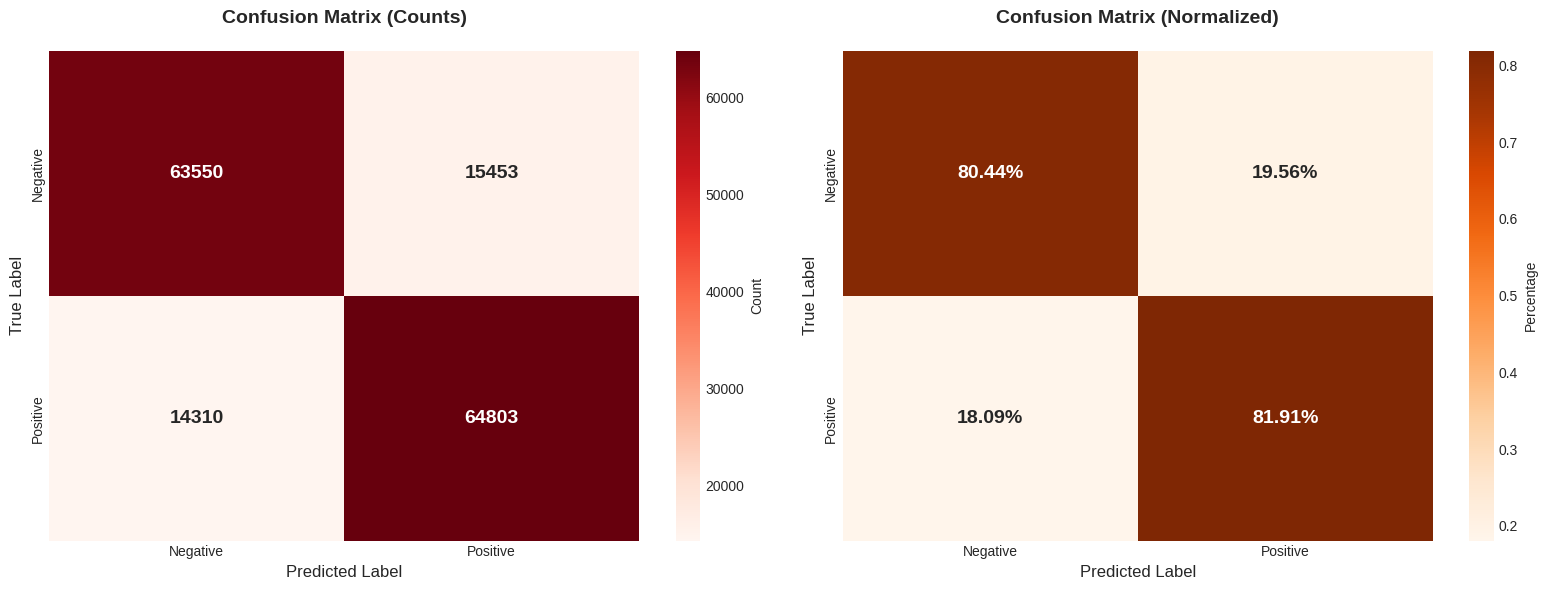


Confusion Matrix Details:
  True Negatives:  63,550
  False Positives: 15,453
  False Negatives: 14,310
  True Positives:  64,803

  Specificity: 0.8044
  Sensitivity: 0.8191

STEP 5: ROC CURVE & AUC SCORE

🎯 ROC-AUC Score: 0.8920
   Interpretation: Good


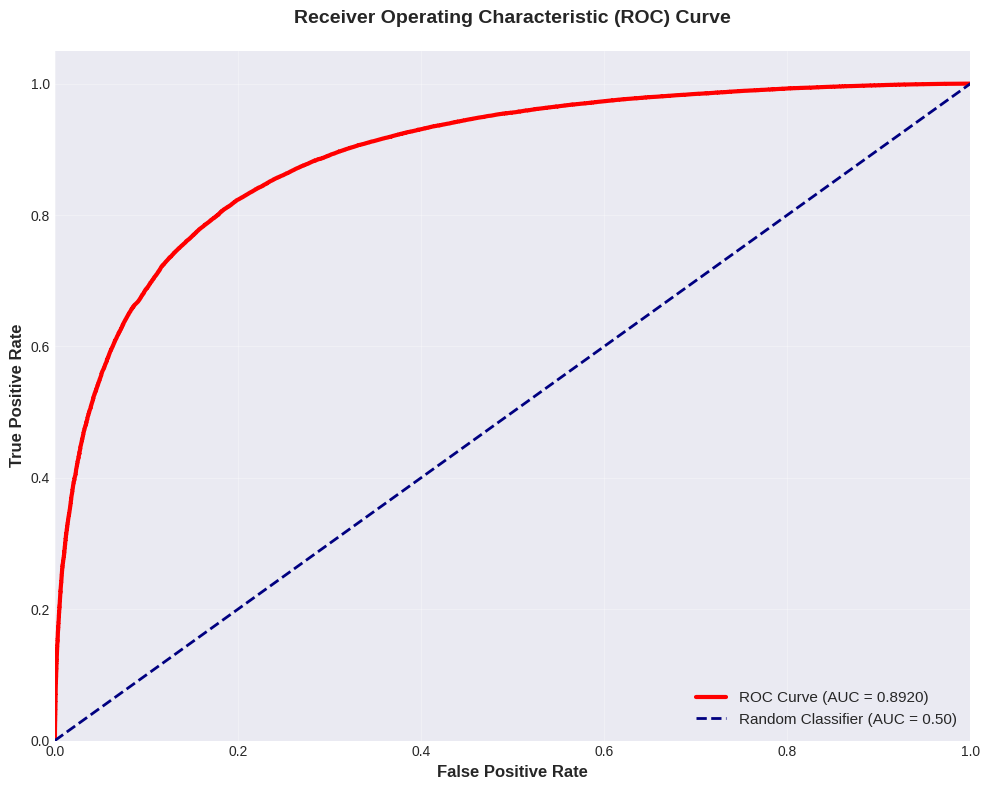


STEP 6: PRECISION-RECALL CURVE

🎯 Average Precision Score: 0.8925


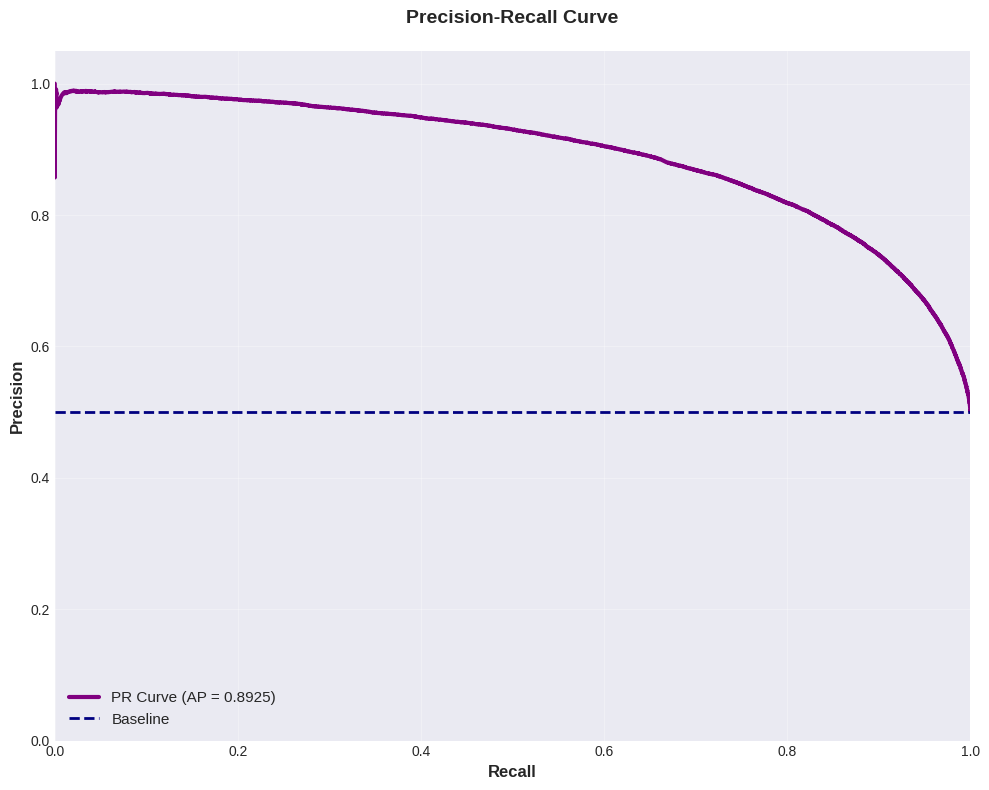


FINAL PERFORMANCE SUMMARY

        Metric Training   Test
     Accuracy   0.8326 0.8118
    Precision   0.8277 0.8075
       Recall   0.8405 0.8191
     F1-Score   0.8340 0.8132
      ROC-AUC      N/A 0.8920
Avg Precision      N/A 0.8925


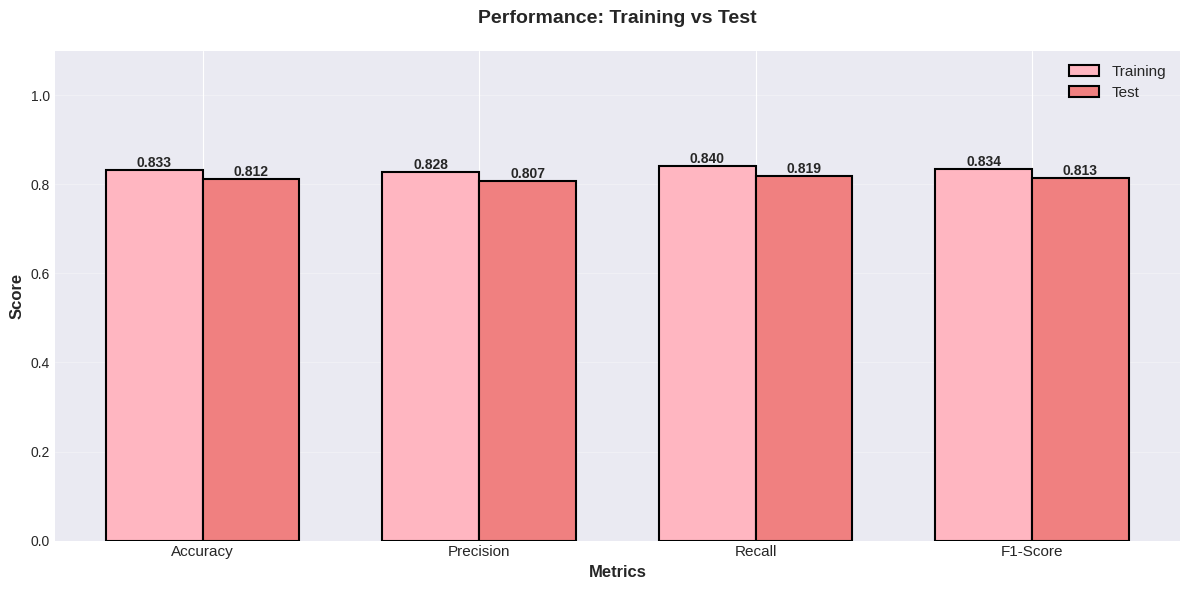


MODEL ANALYSIS

📈 Generalization Analysis:
   • Average Train-Test Difference: 0.0208
   • Status: ✓ Good generalization (slight overfitting)

🎯 Key Findings:
   • Test Accuracy: 81.18%
   • Test F1-Score: 0.8132
   • ROC-AUC: 0.8920
   • Model demonstrates strong performance

💾 Implementation Details:
   • Algorithm: LinearSVC (sklearn)
   • Optimized for large sparse datasets
   • Probability calibration: Platt scaling (sigmoid)
   • Total training time: 38.62s

🔧 Hyperparameters Used:
   • C (regularization): 0.1
   • Max iterations: 3000
   • Dual formulation: False
   • Calibration method: sigmoid (Platt scaling)
   • Calibration CV folds: prefit (Single Model)

📊 Model Complexity:
   • Feature weights computed: 100,000
   • Non-zero weights: 100,000

✅ SVM COMPLETE!

💡 Tips to Improve Performance:
   1. Tune C parameter (try: 0.1, 1.0, 10.0)
   2. Increase max_iter if convergence warning appears
   3. Try class_weight='balanced' for imbalanced data
   4. Use GridSearchCV for opt

15809

In [ ]:
# ============================================
# SVM USING SKLEARN
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, classification_report,
    precision_recall_curve, average_precision_score
)
from scipy.sparse import issparse, load_npz
import time
import gc

# Load data
X_train_tfidf = load_npz('X_train_tfidf.npz')
y_train = np.load('y_train.npy')
X_test_tfidf = load_npz('X_test_tfidf.npz')
y_test = np.load('y_test.npy')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*70)
print("MEMORY-OPTIMIZED SUPPORT VECTOR MACHINE (SKLEARN)")
print("="*70)

# ============================================
# 1. TRAIN MODEL
# ============================================

print("\n" + "="*70)
print("STEP 1: TRAIN SVM MODEL")
print("="*70)

# Clear memory before training
gc.collect()

print("\n🚀 Training started...")
print(f"   Training samples: {X_train_tfidf.shape[0]:,}")
print(f"   Features: {X_train_tfidf.shape[1]:,}")
print(f"   Algorithm: LinearSVC (Linear Support Vector Classification)")
print(f"   Optimized for sparse matrices")
print("-" * 70)

start_time = time.time()

# Using optimal parameters found in previous GridSearchCV
# C=0.1, class_weight='balanced'

# Initialize LinearSVC
# Using optimal C=0.1 and class_weight='balanced' from Round 3
svm_base = LinearSVC(
    C=0.1,
    class_weight='balanced',
    max_iter=3000,
    random_state=42,
    dual=False,
    verbose=0
)

# Train the single optimized model
print("\n🚀 Training Single Optimized SVM...")
svm_base.fit(X_train_tfidf, y_train.ravel())

training_time = time.time() - start_time
print(f"✅ Training completed in {training_time:.2f} seconds")

# Calibrate for probability estimates
print("\n📊 Calibrating for probability estimates...")
calibration_start = time.time()

svm_model = CalibratedClassifierCV(
    estimator=svm_base,
    cv='prefit',          # Use the already trained model
    method='sigmoid'
)

# Calibrate on a subset to save memory/time (as per original optimized script)
sample_size = min(100000, len(y_train))
if len(y_train) > sample_size:
    print(f"   Using {sample_size:,} samples for calibration (memory optimization)")
    indices = np.random.choice(len(y_train), sample_size, replace=False)
    X_calibrate = X_train_tfidf[indices]
    y_calibrate = y_train[indices]
else:
    X_calibrate = X_train_tfidf
    y_calibrate = y_train

svm_model.fit(X_calibrate, y_calibrate.ravel())

calibration_time = time.time() - calibration_start
print(f"✅ Calibration completed in {calibration_time:.2f} seconds")

# Clear memory
gc.collect()

# ============================================
# 2. MAKE PREDICTIONS
# ============================================

print("\n" + "="*70)
print("STEP 2: MAKING PREDICTIONS")
print("="*70)

# Predict on training set
print("\n📊 Predicting on training set...")
pred_start = time.time()
# For prefit CalibratedClassifierCV, predict uses the calibrated probabilities
y_train_pred = svm_model.predict(X_train_tfidf)
print("📊 Calculating probabilities for training set...")
y_train_proba = svm_model.predict_proba(X_train_tfidf)[:, 1]
train_pred_time = time.time() - pred_start
print(f"   Training predictions: {train_pred_time:.2f}s")
gc.collect()

# Predict on test set
print("📊 Predicting on test set...")
pred_start = time.time()
y_test_pred = svm_model.predict(X_test_tfidf)
print("📊 Calculating probabilities for test set...")
y_test_proba = svm_model.predict_proba(X_test_tfidf)[:, 1]
test_pred_time = time.time() - pred_start
print(f"   Test predictions: {test_pred_time:.2f}s")
gc.collect()

print("✅ Predictions completed!")

# ============================================
# 3. EVALUATION METRICS
# ============================================

print("\n" + "="*70)
print("STEP 3: MODEL EVALUATION - TRAINING SET")
print("="*70)

train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

print(f"\n📈 Training Set Performance:")
print(f"   Accuracy:  {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"   Precision: {train_precision:.4f}")
print(f"   Recall:    {train_recall:.4f}")
print(f"   F1-Score:  {train_f1:.4f}")

print("\n" + "="*70)
print("MODEL EVALUATION - TEST SET")
print("="*70)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"\n📈 Test Set Performance:")
print(f"   Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   Precision: {test_precision:.4f}")
print(f"   Recall:    {test_recall:.4f}")
print(f"   F1-Score:  {test_f1:.4f}")

print("\n" + "="*70)
print("DETAILED CLASSIFICATION REPORT")
print("="*70)
print("\n", classification_report(y_test, y_test_pred,
                                   target_names=['Negative', 'Positive'],
                                   digits=4))

# ============================================
# 4. CONFUSION MATRIX
# ============================================

print("\n" + "="*70)
print("STEP 4: CONFUSION MATRIX")
print("="*70)

cm = confusion_matrix(y_test, y_test_pred)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            cbar_kws={'label': 'Count'},
            ax=axes[0],
            annot_kws={'size': 14, 'weight': 'bold'})
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold', pad=20)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Normalized
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Oranges',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            cbar_kws={'label': 'Percentage'},
            ax=axes[1],
            annot_kws={'size': 14, 'weight': 'bold'})
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold', pad=20)
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()

print("\nConfusion Matrix Details:")
print(f"  True Negatives:  {cm[0, 0]:,}")
print(f"  False Positives: {cm[0, 1]:,}")
print(f"  False Negatives: {cm[1, 0]:,}")
print(f"  True Positives:  {cm[1, 1]:,}")

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"\n  Specificity: {specificity:.4f}")
print(f"  Sensitivity: {sensitivity:.4f}")

# ============================================
# 5. ROC CURVE AND AUC
# ============================================

print("\n" + "="*70)
print("STEP 5: ROC CURVE & AUC SCORE")
print("="*70)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

print(f"\n🎯 ROC-AUC Score: {roc_auc:.4f}")

if roc_auc >= 0.90:
    interpretation = "Excellent"
elif roc_auc >= 0.80:
    interpretation = "Good"
elif roc_auc >= 0.70:
    interpretation = "Fair"
else:
    interpretation = "Poor"
print(f"   Interpretation: {interpretation}")

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='red', lw=3,
         label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
         label='Random Classifier (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('Receiver Operating Characteristic (ROC) Curve',
          fontsize=14, fontweight='bold', pad=20)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================
# 6. PRECISION-RECALL CURVE
# ============================================

print("\n" + "="*70)
print("STEP 6: PRECISION-RECALL CURVE")
print("="*70)

precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_test, y_test_proba)
average_precision = average_precision_score(y_test, y_test_proba)

print(f"\n🎯 Average Precision Score: {average_precision:.4f}")

plt.figure(figsize=(10, 8))
plt.plot(recall_curve, precision_curve, color='purple', lw=3,
         label=f'PR Curve (AP = {average_precision:.4f})')
plt.axhline(y=np.sum(y_test)/len(y_test), color='navy', lw=2,
            linestyle='--', label=f'Baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold', pad=20)
plt.legend(loc="lower left", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================
# 7. PERFORMANCE SUMMARY
# ============================================

print("\n" + "="*70)
print("FINAL PERFORMANCE SUMMARY")
print("="*70)

summary_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Avg Precision'],
    'Training': [f"{train_accuracy:.4f}", f"{train_precision:.4f}",
                 f"{train_recall:.4f}", f"{train_f1:.4f}", "N/A", "N/A"],
    'Test': [f"{test_accuracy:.4f}", f"{test_precision:.4f}",
             f"{test_recall:.4f}", f"{test_f1:.4f}",
             f"{roc_auc:.4f}", f"{average_precision:.4f}"]
}

summary_df = pd.DataFrame(summary_data)
print("\n", summary_df.to_string(index=False))

# Visualize metrics comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
train_scores = [train_accuracy, train_precision, train_recall, train_f1]
test_scores = [test_accuracy, test_precision, test_recall, test_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, train_scores, width, label='Training',
               color='lightpink', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, test_scores, width, label='Test',
               color='lightcoral', edgecolor='black', linewidth=1.5)

ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Performance: Training vs Test', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)
ax.legend(fontsize=11)
ax.set_ylim([0, 1.1])
ax.grid(True, axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom',
                fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================
# 8. MODEL ANALYSIS
# ============================================

print("\n" + "="*70)
print("MODEL ANALYSIS")
print("="*70)

# Overfitting analysis
avg_diff = np.mean([
    abs(train_accuracy - test_accuracy),
    abs(train_precision - test_precision),
    abs(train_recall - test_recall),
    abs(train_f1 - test_f1)
])

print(f"\n📈 Generalization Analysis:")
print(f"   • Average Train-Test Difference: {avg_diff:.4f}")

if avg_diff < 0.02:
    print(f"   • Status: ✓ Excellent generalization (minimal overfitting)")
elif avg_diff < 0.05:
    print(f"   • Status: ✓ Good generalization (slight overfitting)")
elif avg_diff < 0.10:
    print(f"   • Status: ⚠ Moderate overfitting")
else:
    print(f"   • Status: ⚠ Significant overfitting detected")

print(f"\n🎯 Key Findings:")
print(f"   • Test Accuracy: {test_accuracy:.2%}")
print(f"   • Test F1-Score: {test_f1:.4f}")
print(f"   • ROC-AUC: {roc_auc:.4f}")
print(f"   • Model demonstrates {'strong' if test_accuracy > 0.75 else 'moderate'} performance")

print(f"\n💾 Implementation Details:")
print(f"   • Algorithm: LinearSVC (sklearn)")
print(f"   • Optimized for large sparse datasets")
print(f"   • Probability calibration: Platt scaling (sigmoid)")
print(f"   • Total training time: {training_time:.2f}s")

print(f"\n🔧 Hyperparameters Used:")
print(f"   • C (regularization): {svm_base.C}")
print(f"   • Max iterations: {svm_base.max_iter}")
print(f"   • Dual formulation: {svm_base.dual}")
print(f"   • Calibration method: sigmoid (Platt scaling)")
print(f"   • Calibration CV folds: prefit (Single Model)")

# Get support vectors info (if available)
try:
    n_support = len(svm_base.coef_[0])
    print(f"\n📊 Model Complexity:")
    print(f"   • Feature weights computed: {n_support:,}")
    print(f"   • Non-zero weights: {np.count_nonzero(svm_base.coef_):,}")
except:
    pass

print("\n" + "="*70)
print("✅ SVM COMPLETE!")
print("="*70)

print("\n💡 Tips to Improve Performance:")
print("   1. Tune C parameter (try: 0.1, 1.0, 10.0)")
print("   2. Increase max_iter if convergence warning appears")
print("   3. Try class_weight='balanced' for imbalanced data")
print("   4. Use GridSearchCV for optimal hyperparameters")

# Final cleanup
gc.collect()


In [ ]:
# ============================================
# RANDOM FOREST CLASSIFIER
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, classification_report,
    precision_recall_curve, average_precision_score
)
from scipy.sparse import load_npz
import time
import gc

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*70)
print("OPTIMIZED RANDOM FOREST CLASSIFIER")
print("="*70)

# ============================================
# 1. LOAD PREPROCESSED DATA
# ============================================

print("\n" + "="*70)
print("LOADING PREPROCESSED DATA")
print("="*70)

# Load TF-IDF matrices (sparse format)
X_train_tfidf = load_npz('X_train_tfidf.npz')
X_test_tfidf = load_npz('X_test_tfidf.npz')

# Load labels
y_train = np.load('y_train.npy').flatten()  # Flatten to 1D
y_test = np.load('y_test.npy').flatten()

print(f"✅ Data loaded successfully!")
print(f"Training data shape: {X_train_tfidf.shape}")
print(f"Test data shape: {X_test_tfidf.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")

# Check class distribution
print(f"\nClass distribution in training set:")
unique, counts = np.unique(y_train, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  Class {label}: {count:,} ({count/len(y_train)*100:.2f}%)")

# ============================================
# 2. HYPERPARAMETER CONFIGURATION
# ============================================

print("\n" + "="*70)
print("HYPERPARAMETER TUNING WITH GRIDSEARCHCV")
print("="*70)

# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [200, 300],              # Number of trees
    'max_depth': [25, 30, 35],               # Maximum depth
    'min_samples_split': [5, 10],            # Minimum samples to split
    'min_samples_leaf': [2, 4],              # Minimum samples in leaf
    'max_features': ['sqrt', 'log2'],        # Features per split
    'class_weight': ['balanced']             # Handle class imbalance
}

print("Parameter Grid for GridSearchCV:")
for key, value in param_grid.items():
    print(f"  {key}: {value}")

# Base Random Forest model
base_rf = RandomForestClassifier(
    bootstrap=True,
    n_jobs=-1,
    random_state=42,
    verbose=0  # Reduce verbosity for GridSearch
)

print(f"\n🔍 Starting GridSearchCV...")
print(f"   Total combinations to test: {np.prod([len(v) for v in param_grid.values()])}")
print(f"   Using 3-fold cross-validation")
print(f"   This may take 30-60 minutes depending on your CPU...")
print("-" * 70)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=base_rf,
    param_grid=param_grid,
    cv=3,                    # 3-fold cross-validation
    scoring='accuracy',      # Optimize for accuracy
    n_jobs=-1,              # Use all CPU cores
    verbose=2,              # Show progress
    return_train_score=True
)

# ============================================
# 3. TRAIN RANDOM FOREST MODEL WITH GRIDSEARCH
# ============================================

print("\n" + "="*70)
print("TRAINING RANDOM FOREST WITH GRIDSEARCH")
print("="*70)

start_time = time.time()

# Fit GridSearchCV
grid_search.fit(X_train_tfidf, y_train)

training_time = time.time() - start_time

print("-" * 70)
print(f"✅ GridSearchCV completed in {training_time/60:.2f} minutes ({training_time:.2f} seconds)")

# Get best parameters and best score
print("\n" + "="*70)
print("BEST PARAMETERS FOUND")
print("="*70)

print(f"\n🏆 Best Cross-Validation Accuracy: {grid_search.best_score_:.4f} ({grid_search.best_score_*100:.2f}%)")
print(f"\nBest Parameters:")
for key, value in grid_search.best_params_.items():
    print(f"  {key}: {value}")

# Get the best model
rf_model = grid_search.best_estimator_

# Display CV results summary
print("\n" + "="*70)
print("TOP 5 PARAMETER COMBINATIONS")
print("="*70)

cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results_sorted = cv_results.sort_values('rank_test_score')
top_5 = cv_results_sorted.head(5)[['params', 'mean_test_score', 'std_test_score', 'mean_train_score']]

print("\n")
for idx, row in top_5.iterrows():
    print(f"Rank {row.name + 1}:")
    print(f"  Params: {row['params']}")
    print(f"  CV Accuracy: {row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f})")
    print(f"  Train Accuracy: {row['mean_train_score']:.4f}")
    print()

# Garbage collection
gc.collect()

# ============================================
# 4. MODEL INFORMATION
# ============================================

print("\n" + "="*70)
print("MODEL INFORMATION")
print("="*70)

print(f"\nNumber of trees: {len(rf_model.estimators_)}")
print(f"Number of features: {rf_model.n_features_in_}")
print(f"Number of classes: {rf_model.n_classes_}")
print(f"Classes: {rf_model.classes_}")

# ============================================
# 5. FEATURE IMPORTANCE (TOP 20)
# ============================================

print("\n" + "="*70)
print("TOP 20 MOST IMPORTANT FEATURES")
print("="*70)

# Get feature importances
import pickle
with open('tfidf_vectorizer.pickle', 'rb') as handle:
    vectorizer = pickle.load(handle)

feature_names = vectorizer.get_feature_names_out()
importances = rf_model.feature_importances_

# Get top 20 features
top_indices = np.argsort(importances)[-20:][::-1]
top_features = [(feature_names[i], importances[i]) for i in top_indices]

print("\nTop 20 Features:")
for i, (feature, importance) in enumerate(top_features, 1):
    print(f"  {i:2d}. {feature:20s}: {importance:.6f}")

# Visualize top 20 features
plt.figure(figsize=(12, 8))
features = [f[0] for f in top_features]
importance_values = [f[1] for f in top_features]

plt.barh(range(len(features)), importance_values, color='steelblue', edgecolor='black')
plt.yticks(range(len(features)), features)
plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.title('Top 20 Most Important Features', fontsize=14, fontweight='bold', pad=20)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ============================================
# 6. MAKE PREDICTIONS
# ============================================

print("\n" + "="*70)
print("MAKING PREDICTIONS")
print("="*70)

# Predict on training set
print("\n📊 Predicting on training set...")
start_time = time.time()
y_train_pred = rf_model.predict(X_train_tfidf)
y_train_proba = rf_model.predict_proba(X_train_tfidf)[:, 1]
train_pred_time = time.time() - start_time
print(f"   Training predictions completed in {train_pred_time:.2f} seconds")

# Predict on test set
print("📊 Predicting on test set...")
start_time = time.time()
y_test_pred = rf_model.predict(X_test_tfidf)
y_test_proba = rf_model.predict_proba(X_test_tfidf)[:, 1]
test_pred_time = time.time() - start_time
print(f"   Test predictions completed in {test_pred_time:.2f} seconds")

print("✅ All predictions completed!")

gc.collect()

# ============================================
# 7. EVALUATION METRICS
# ============================================

print("\n" + "="*70)
print("MODEL EVALUATION - TRAINING SET")
print("="*70)

train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

print(f"\n📈 Training Set Performance:")
print(f"   Accuracy:  {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"   Precision: {train_precision:.4f}")
print(f"   Recall:    {train_recall:.4f}")
print(f"   F1-Score:  {train_f1:.4f}")

print("\n" + "="*70)
print("MODEL EVALUATION - TEST SET")
print("="*70)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"\n📈 Test Set Performance:")
print(f"   Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   Precision: {test_precision:.4f}")
print(f"   Recall:    {test_recall:.4f}")
print(f"   F1-Score:  {test_f1:.4f}")

print("\n" + "="*70)
print("DETAILED CLASSIFICATION REPORT - TEST SET")
print("="*70)
print("\n", classification_report(y_test, y_test_pred,
                                   target_names=['Negative', 'Positive'],
                                   digits=4))

# ============================================
# 8. CONFUSION MATRIX
# ============================================

print("\n" + "="*70)
print("CONFUSION MATRIX")
print("="*70)

cm = confusion_matrix(y_test, y_test_pred)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            cbar_kws={'label': 'Count'},
            ax=axes[0],
            annot_kws={'size': 14, 'weight': 'bold'})
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold', pad=20)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Normalized
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            cbar_kws={'label': 'Percentage'},
            ax=axes[1],
            annot_kws={'size': 14, 'weight': 'bold'})
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold', pad=20)
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()

print("\nConfusion Matrix Details:")
print(f"  True Negatives:  {cm[0, 0]:,}")
print(f"  False Positives: {cm[0, 1]:,}")
print(f"  False Negatives: {cm[1, 0]:,}")
print(f"  True Positives:  {cm[1, 1]:,}")

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"\n  Specificity (True Negative Rate): {specificity:.4f}")
print(f"  Sensitivity (True Positive Rate): {sensitivity:.4f}")

# ============================================
# 9. ROC CURVE AND AUC
# ============================================

print("\n" + "="*70)
print("ROC CURVE & AUC SCORE")
print("="*70)

fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

print(f"\n🎯 ROC-AUC Score: {roc_auc:.4f}")

if roc_auc >= 0.90:
    interpretation = "Excellent"
elif roc_auc >= 0.80:
    interpretation = "Good"
elif roc_auc >= 0.70:
    interpretation = "Fair"
else:
    interpretation = "Poor"
print(f"   Interpretation: {interpretation}")

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkgreen', lw=3,
         label=f'Random Forest (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
         label='Random Classifier (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curve - Random Forest', fontsize=14, fontweight='bold', pad=20)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================
# 10. PRECISION-RECALL CURVE
# ============================================

print("\n" + "="*70)
print("PRECISION-RECALL CURVE")
print("="*70)

precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_test, y_test_proba)
average_precision = average_precision_score(y_test, y_test_proba)

print(f"\n🎯 Average Precision Score: {average_precision:.4f}")

plt.figure(figsize=(10, 8))
plt.plot(recall_curve, precision_curve, color='darkgreen', lw=3,
         label=f'Random Forest (AP = {average_precision:.4f})')
plt.axhline(y=np.sum(y_test)/len(y_test), color='navy', lw=2,
            linestyle='--', label='Baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title('Precision-Recall Curve - Random Forest', fontsize=14, fontweight='bold', pad=20)
plt.legend(loc="lower left", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================
# 11. PERFORMANCE SUMMARY
# ============================================

print("\n" + "="*70)
print("FINAL PERFORMANCE SUMMARY")
print("="*70)

summary_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Avg Precision'],
    'Training': [f"{train_accuracy:.4f}", f"{train_precision:.4f}",
                 f"{train_recall:.4f}", f"{train_f1:.4f}", "N/A", "N/A"],
    'Test': [f"{test_accuracy:.4f}", f"{test_precision:.4f}",
             f"{test_recall:.4f}", f"{test_f1:.4f}",
             f"{roc_auc:.4f}", f"{average_precision:.4f}"]
}

summary_df = pd.DataFrame(summary_data)
print("\n", summary_df.to_string(index=False))

# Visualize metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
train_scores = [train_accuracy, train_precision, train_recall, train_f1]
test_scores = [test_accuracy, test_precision, test_recall, test_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, train_scores, width, label='Training',
               color='lightgreen', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, test_scores, width, label='Test',
               color='darkgreen', edgecolor='black', linewidth=1.5)

ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Random Forest Performance: Training vs Test', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)
ax.legend(fontsize=11)
ax.set_ylim([0, 1.1])
ax.grid(True, axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom',
                fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================
# 12. TRAINING TIME SUMMARY
# ============================================

print("\n" + "="*70)
print("TIME SUMMARY")
print("="*70)

print(f"\nTraining time: {training_time/60:.2f} minutes")
print(f"Training prediction time: {train_pred_time:.2f} seconds")
print(f"Test prediction time: {test_pred_time:.2f} seconds")
print(f"Total time: {(training_time + train_pred_time + test_pred_time)/60:.2f} minutes")

print("\n" + "="*70)
print("✅ RANDOM FOREST - COMPLETE!")
print("="*70)


OPTIMIZED RANDOM FOREST CLASSIFIER

LOADING PREPROCESSED DATA
✅ Data loaded successfully!
Training data shape: (1423036, 100000)
Test data shape: (158116, 100000)
Training labels shape: (1423036,)
Test labels shape: (158116,)

Class distribution in training set:
  Class 0: 711,024 (49.97%)
  Class 1: 712,012 (50.03%)

HYPERPARAMETER TUNING WITH GRIDSEARCHCV
Parameter Grid for GridSearchCV:
  n_estimators: [200, 300]
  max_depth: [25, 30, 35]
  min_samples_split: [5, 10]
  min_samples_leaf: [2, 4]
  max_features: ['sqrt', 'log2']
  class_weight: ['balanced']

🔍 Starting GridSearchCV...
   Total combinations to test: 48
   Using 3-fold cross-validation
   This may take 30-60 minutes depending on your CPU...
----------------------------------------------------------------------

TRAINING RANDOM FOREST WITH GRIDSEARCH
Fitting 3 folds for each of 48 candidates, totalling 144 fits


KeyboardInterrupt: 